In [1]:
#from pypads.app.base import PyPads
from datetime import datetime  

# CIFAR 10 dataset - Numpy
#import os
import platform
import pickle

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

import torch  
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
class VGG_11(nn.Module):
    
    def __init__(self):
        super(VGG_11,self).__init__()
        
        # Setting up the layers of Convolutional neural network
        in_size = 3                 # number of channel in the input image
    
        hid1_size = 64              # no of output channel from first CNN layer

        hid2_size = 128             # no of output channel from second CNN layer

        hid3_size = 256             # no of output channel from third CNN layer

        hid4_size = 512             # no of output channel from forth CNN layer

        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        out_size = len(classes)     # no of categories in the dataset

        k_conv_size = 3             # 3x3 convolutional kernel

        conv_stride = 1             # conv stride 1

        conv_pad = 1                # conv padding 1

        maxpool_kernel = 2          # maxpool layer kernel size 2 x 2

        maxpool_stride = 2          # maxpool layer stride 2

        self.convLayer = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size, stride=conv_stride, padding=conv_pad),    # conv layer
            nn.BatchNorm2d(hid1_size),
            #nn.LocalResponseNorm(64),
            nn.ReLU(),                              # Activation layer
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid1_size,hid2_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid2_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            
            nn.Conv2d(hid3_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid3_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride), 
            
            nn.Flatten(),
            
            nn.Linear(512, out_size)
            
        )
        
            
        
    def forward(self,x):
            out = self.convLayer(x)
            
            return out 
        
vgg_11 = VGG_11()

In [3]:
# Unpickle a data item
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

# Load CIFAR-10 batch
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32)
        Y = np.array(Y)
        return X, Y   

# Load full CIFAR-10 dataset
def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=0, num_test=10000):
    # Load the raw CIFAR-10 data
    dirname = os.path.dirname(__file__)
    cifar10_dir = 'CIFAR-10-DS/cifar-10-batches-py/'
    filename = os.path.join(dirname, cifar10_dir)
    
    X_train, y_train, X_test, y_test = load_CIFAR10(filename)

    num_training=X_train.shape[0]
    num_test=X_test.shape[0]

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    #Save dataset in npy files
    save('train_data.npy', x_train)
    save('train_label.npy', y_train)

    save('test_data.npy', x_test)
    save('test_label.npy', y_test)

    # Loading from npy files
    x_train = load('train_data.npy')
    y_train = load('train_label.npy')

    x_test = load('test_data.npy')
    y_test = load('test_label.npy')

    #Shuffle data 
    data = list(zip(x_train, y_train))
    np.random.shuffle(data)
    x_train, y_train = zip(*data)

    # Save the shuffled data
    save('train_data.npy', x_train)
    save('train_label.npy', y_train)

    #return x_train, y_train, x_test, y_test 

In [4]:
#Create custom size batches of the dataset
def createBatches(data,batch_size_required,device="cpu"):
    batch_size = int(len(data)/batch_size_required)
    res=[]
    
    for i in range (batch_size):
        batched_data = data[i*batch_size_required:i*batch_size_required+batch_size_required]
        res.append(batched_data)


    if (device == "cpu"):
        res = np.asarray(res)

    elif (device == "cuda"):
        return res
    
    return res


def useLossFunction():
    criterion = nn.CrossEntropyLoss()
    return criterion

In [5]:
def useOptimizerFunction(name, learning_rate=0.01, momentum_val = 0.9):
    #learning_rate = 0.01                        # Learning rate
    #momentum_val = 0.9                          # Momentum value
    print('learning rate ', learning_rate)
    optimizer=''
    if(name == 'Adadelta'):
        optimizer = optim.Adadelta(vgg_11.parameters())

    elif(name=='SGD'):
        optimizer = optim.SGD(vgg_11.parameters(), lr=learning_rate, momentum=momentum_val)
    
    elif(name=='NAG'):
        optimizer = optim.SGD(vgg_11.parameters(), lr=learning_rate, momentum=momentum_val, dampening=0, weight_decay=0, nesterov=True)

    return optimizer

In [6]:
running_loss_arr = []

def trainNetwork(max_epoch, x_train_tensor,y_train_tensor,optimizer,lossFun,dev):
    print('dev ', dev)
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(x_train_tensor, 0):

            inputs = data
            labels = y_train_tensor[i]
            optimizer.zero_grad()

            outputs = vgg_11(inputs)
            
            labels = labels.to(device=dev, dtype=torch.int64)
            
            loss = lossFun(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_arr += loss.item()
            
            # print statistics        
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))

                running_loss = 0.0

    print('Finished Training')

In [7]:

def trainNetworkOnGPU(max_epoch, x_train_tensor,y_train_tensor,optimizer,lossFun,dev):
    print('dev ', dev)
    loss_value = []
    if(dev.type == "cuda"):
        for epoch in range(max_epoch):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(x_train_tensor, 0):

                inputs = data
                #input.cuda()

                labels = y_train_tensor[i]
                labels.cuda()

                optimizer.zero_grad()

                vgg_11_gpu = vgg_11.cuda()
                outputs = vgg_11_gpu(inputs)
                
                labels = labels.to(device=dev, dtype=torch.int64)
                
                loss = lossFun(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                loss_value.append(running_loss)
                # print statistics        
                #if i % 100 == 99:    # print every 100 mini-batches
                #    
                    
                    #running_loss = 0.0
            print('Loss:', (running_loss/i))
            

        print('Finished Training on GPU')
        return loss_value
    else:
        print('GPU not present')

In [8]:
#Accuracy of individual classes and overall dataset
def AccuracyOfIndividualClassesAndDataset(x_test_t,y_test_t,bs):
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for i, data in enumerate(x_test_t, 0):
            #images, labels = data

            images = data
            labels = y_test_t[i]

            outputs = vgg_11(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                
                class_correct[int(label.item())] += c[i].item()
                class_total[int(label.item())] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
    print('Accuracy of the network on the %d test images: %.2f %%' % (len(y_test_t)*bs,100 * correct / total))

In [9]:
def saveTrainedModel(name):
    if (name):
        PATH = './' + name + '.pth'
    else:
         PATH = './cifar_vgg11.pth'

    
    torch.save(vgg_11.state_dict(), PATH)

In [10]:
#Main function
begin_time = datetime.now()   

# Initializing pypads
#tracker = PyPads( autostart=True)
#tracker.start_track(experiment_name="Effect of GPUs - VGG 11")

torch.manual_seed(0)            # to set same random number to all devices [4]

device = torch.device("cpu")
max_epoch_num = 2               # Maximun numbe of epochs

#Get train and test dataset
#get_CIFAR10_data()

# Load dataset from npy files
x_train = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_data.npy')
y_train = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_label.npy')

x_test = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_data.npy')
y_test = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_label.npy')

#Divide the dataset into small batches
batch_size = 64
x_train = createBatches(x_train,batch_size)
y_train = createBatches(y_train,batch_size)

x_test = createBatches(x_test,batch_size)
y_test = createBatches(y_test,batch_size)


# Convert npArray to tensor
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

x_test_tensor = torch.as_tensor(x_test)
y_test_tensor = torch.as_tensor(y_test)

criterion = useLossFunction()

# Adadelta Optimizer
# optimizer=useOptimizerFunction('Adadelta')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)

# # SGD Optimizer
# optimizer=useOptimizerFunction('SGD')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)

# # NAG optimzer
# optimizer=useOptimizerFunction('NAG')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)


print('Time required to run the model on CPU is', datetime.now() - begin_time)

Time required to run the model on CPU is 0:00:00.357223


learning rate  0.01
dev  cuda
Loss: 1.2899913970476542
Loss: 0.7965504499582144
Finished Training on GPU
Accuracy of plane : 78.18 %
Accuracy of   car : 82.00 %
Accuracy of  bird : 72.15 %
Accuracy of   cat : 41.10 %
Accuracy of  deer : 63.64 %
Accuracy of   dog : 65.52 %
Accuracy of  frog : 80.36 %
Accuracy of horse : 66.67 %
Accuracy of  ship : 87.72 %
Accuracy of truck : 73.08 %
Accuracy of the network on the 9984 test images: 72.89 %
Time required to run the model on GPU is 0:00:46.745843


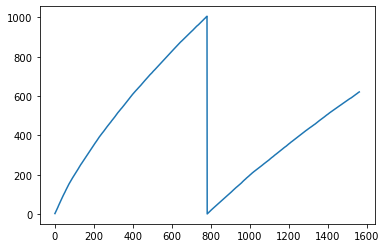

In [11]:
# If GPU is present run the code on the GPU 
begin_time = datetime.now()  

x_train_gpu = []
y_train_gpu = []
x_test_gpu = []
y_test_gpu = []
    
if (torch.cuda.is_available()):

    device = torch.device('cuda')  
    # Load data from the numpy files into tensor which are stored on GPU
    x_train_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_data.npy')).cuda()
    y_train_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_label.npy')).cuda()
    x_test_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_data.npy')).cuda()
    y_test_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_label.npy')).cuda()

    #Store model on GPU
    #vgg_11 = VGG_11.cuda()

    #Divide the dataset into small batches'
    x_train_gpu = createBatches(x_train_gpu,batch_size, "cuda")
    y_train_gpu = createBatches(y_train_gpu,batch_size, "cuda")

    x_test_gpu = createBatches(x_test_gpu,batch_size, "cuda")
    y_test_gpu = createBatches(y_test_gpu,batch_size, "cuda")


    # Adadelta Optimizer - GPU
    # optimizer=useOptimizerFunction('Adadelta')
    # trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    # AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)

    # SGD Optimizer - GPU
    optimizer=useOptimizerFunction('SGD')
    pltdata = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)

    # NAG optimzer - GPU
    # optimizer=useOptimizerFunction('NAG')
    # trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    # AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
    print('Time required to run the model on GPU is', datetime.now() - begin_time) 
    plt.plot(pltdata)


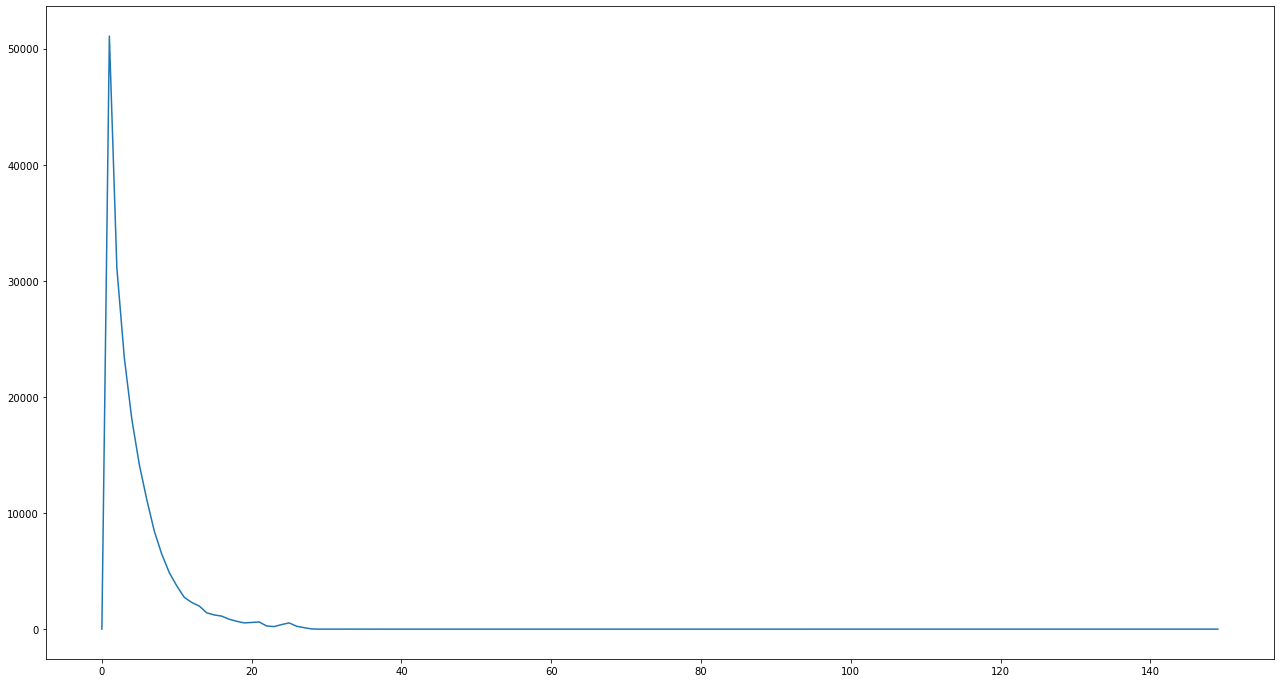

In [13]:
avg = 0
avgLossPerEpoch = []
for i in range(len(pltdata)):
    avg = avg + pltdata[i]
    if(i%780==0):
        avgLossPerEpoch.append(avg)
        avg = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch[0:150])       

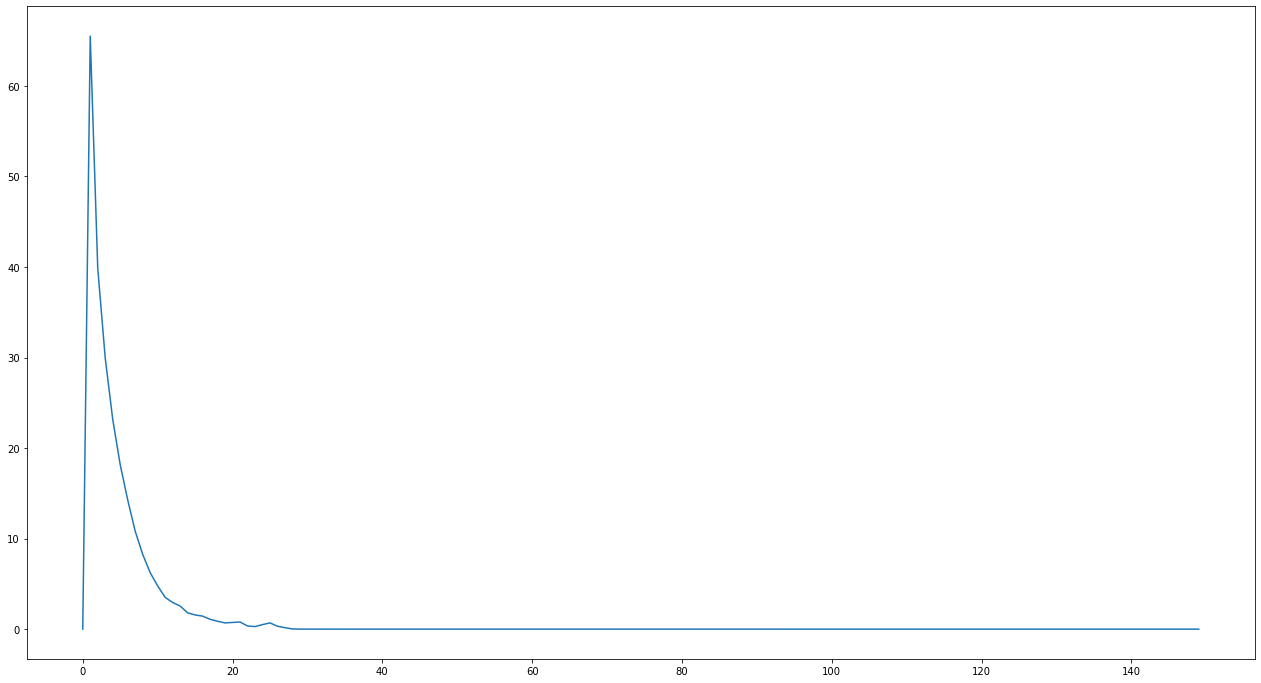

In [14]:
avg = 0
avgLossPerEpoch = []
for i in range(len(pltdata)):
    avg = avg + pltdata[i]
    if(i%780==0):
        avgLossPerEpoch.append(avg/780)
        avg = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch[20:150])       

learning rate  0.05
dev  cuda
[1,   100] loss: 0.0000028687
[1,   200] loss: 0.0000029121
[1,   300] loss: 0.0000027625
[1,   400] loss: 0.0000025864
[1,   500] loss: 0.0000024852
[1,   600] loss: 0.0000025943
[1,   700] loss: 0.0000030734
[2,   100] loss: 0.0000027705
[2,   200] loss: 0.0000028110
[2,   300] loss: 0.0000026653
[2,   400] loss: 0.0000024968
[2,   500] loss: 0.0000023997
[2,   600] loss: 0.0000025057
[2,   700] loss: 0.0000029625
[3,   100] loss: 0.0000026772
[3,   200] loss: 0.0000027164
[3,   300] loss: 0.0000025752
[3,   400] loss: 0.0000024142
[3,   500] loss: 0.0000023202
[3,   600] loss: 0.0000024221
[3,   700] loss: 0.0000028600
[4,   100] loss: 0.0000025910
[4,   200] loss: 0.0000026279
[4,   300] loss: 0.0000024909
[4,   400] loss: 0.0000023367
[4,   500] loss: 0.0000022452
[4,   600] loss: 0.0000023444
[4,   700] loss: 0.0000027654
[5,   100] loss: 0.0000025097
[5,   200] loss: 0.0000025451
[5,   300] loss: 0.0000024119
[5,   400] loss: 0.0000022640
[5,   500]

[39,   100] loss: 0.0000012218
[39,   200] loss: 0.0000012334
[39,   300] loss: 0.0000011707
[39,   400] loss: 0.0000011169
[39,   500] loss: 0.0000010664
[39,   600] loss: 0.0000011135
[39,   700] loss: 0.0000012973
[40,   100] loss: 0.0000012045
[40,   200] loss: 0.0000012154
[40,   300] loss: 0.0000011535
[40,   400] loss: 0.0000011006
[40,   500] loss: 0.0000010506
[40,   600] loss: 0.0000010975
[40,   700] loss: 0.0000012782
[41,   100] loss: 0.0000011866
[41,   200] loss: 0.0000011976
[41,   300] loss: 0.0000011371
[41,   400] loss: 0.0000010847
[41,   500] loss: 0.0000010357
[41,   600] loss: 0.0000010814
[41,   700] loss: 0.0000012598
[42,   100] loss: 0.0000011698
[42,   200] loss: 0.0000011804
[42,   300] loss: 0.0000011210
[42,   400] loss: 0.0000010692
[42,   500] loss: 0.0000010209
[42,   600] loss: 0.0000010663
[42,   700] loss: 0.0000012419
[43,   100] loss: 0.0000011533
[43,   200] loss: 0.0000011638
[43,   300] loss: 0.0000011045
[43,   400] loss: 0.0000010548
[43,   5

[76,   700] loss: 0.0000008361
[77,   100] loss: 0.0000007825
[77,   200] loss: 0.0000007867
[77,   300] loss: 0.0000007465
[77,   400] loss: 0.0000007204
[77,   500] loss: 0.0000006853
[77,   600] loss: 0.0000007143
[77,   700] loss: 0.0000008281
[78,   100] loss: 0.0000007756
[78,   200] loss: 0.0000007794
[78,   300] loss: 0.0000007392
[78,   400] loss: 0.0000007135
[78,   500] loss: 0.0000006789
[78,   600] loss: 0.0000007077
[78,   700] loss: 0.0000008203
[79,   100] loss: 0.0000007685
[79,   200] loss: 0.0000007720
[79,   300] loss: 0.0000007326
[79,   400] loss: 0.0000007073
[79,   500] loss: 0.0000006726
[79,   600] loss: 0.0000007010
[79,   700] loss: 0.0000008126
[80,   100] loss: 0.0000007609
[80,   200] loss: 0.0000007649
[80,   300] loss: 0.0000007254
[80,   400] loss: 0.0000007006
[80,   500] loss: 0.0000006665
[80,   600] loss: 0.0000006948
[80,   700] loss: 0.0000008051
[81,   100] loss: 0.0000007543
[81,   200] loss: 0.0000007578
[81,   300] loss: 0.0000007189
[81,   4

[114,   300] loss: 0.0000005528
[114,   400] loss: 0.0000005370
[114,   500] loss: 0.0000005104
[114,   600] loss: 0.0000005308
[114,   700] loss: 0.0000006133
[115,   100] loss: 0.0000005779
[115,   200] loss: 0.0000005790
[115,   300] loss: 0.0000005490
[115,   400] loss: 0.0000005333
[115,   500] loss: 0.0000005072
[115,   600] loss: 0.0000005272
[115,   700] loss: 0.0000006091
[116,   100] loss: 0.0000005738
[116,   200] loss: 0.0000005750
[116,   300] loss: 0.0000005448
[116,   400] loss: 0.0000005298
[116,   500] loss: 0.0000005036
[116,   600] loss: 0.0000005237
[116,   700] loss: 0.0000006047
[117,   100] loss: 0.0000005698
[117,   200] loss: 0.0000005710
[117,   300] loss: 0.0000005412
[117,   400] loss: 0.0000005262
[117,   500] loss: 0.0000005000
[117,   600] loss: 0.0000005205
[117,   700] loss: 0.0000006009
[118,   100] loss: 0.0000005661
[118,   200] loss: 0.0000005672
[118,   300] loss: 0.0000005375
[118,   400] loss: 0.0000005228
[118,   500] loss: 0.0000004967
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 85.71 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.09 %


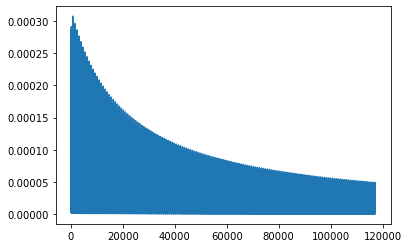

In [15]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.05)
pltdata1 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata1)

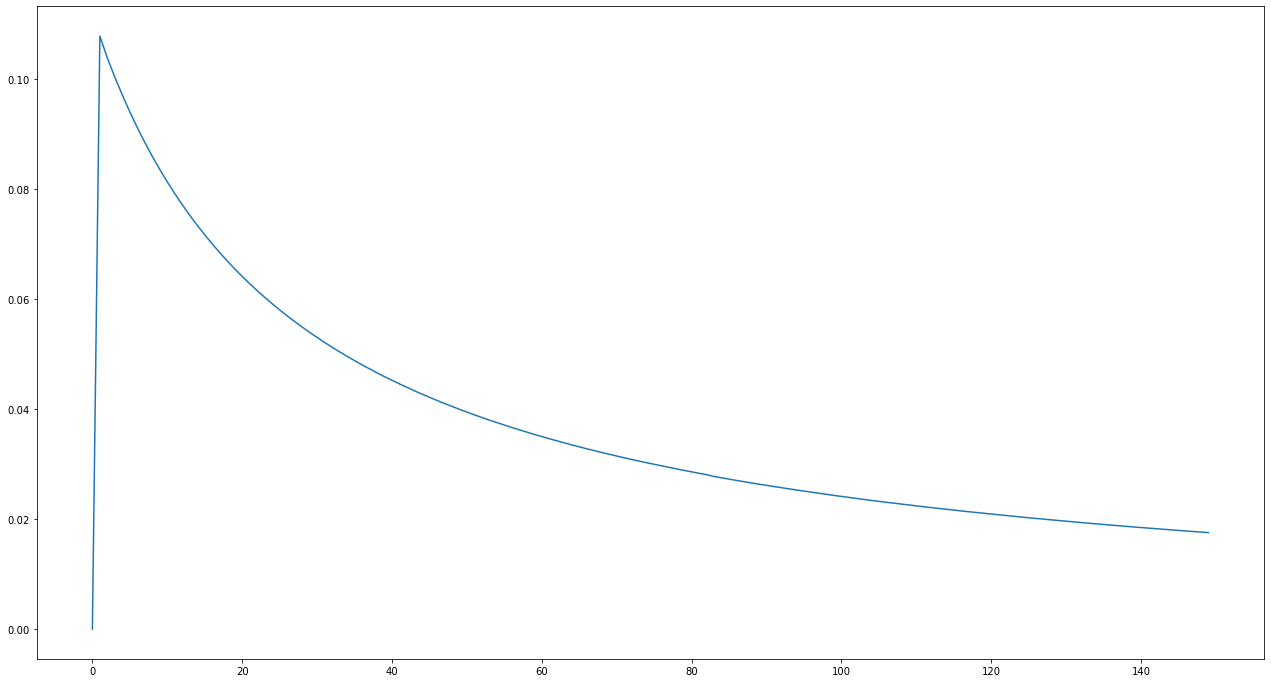

In [16]:
avg1 = 0
avgLossPerEpoch1 = []
for i in range(len(pltdata1)):
    avg1 = avg1 + pltdata1[i]
    if(i%780==0):
        avgLossPerEpoch1.append(avg1)
        avg1 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch1[0:150])       

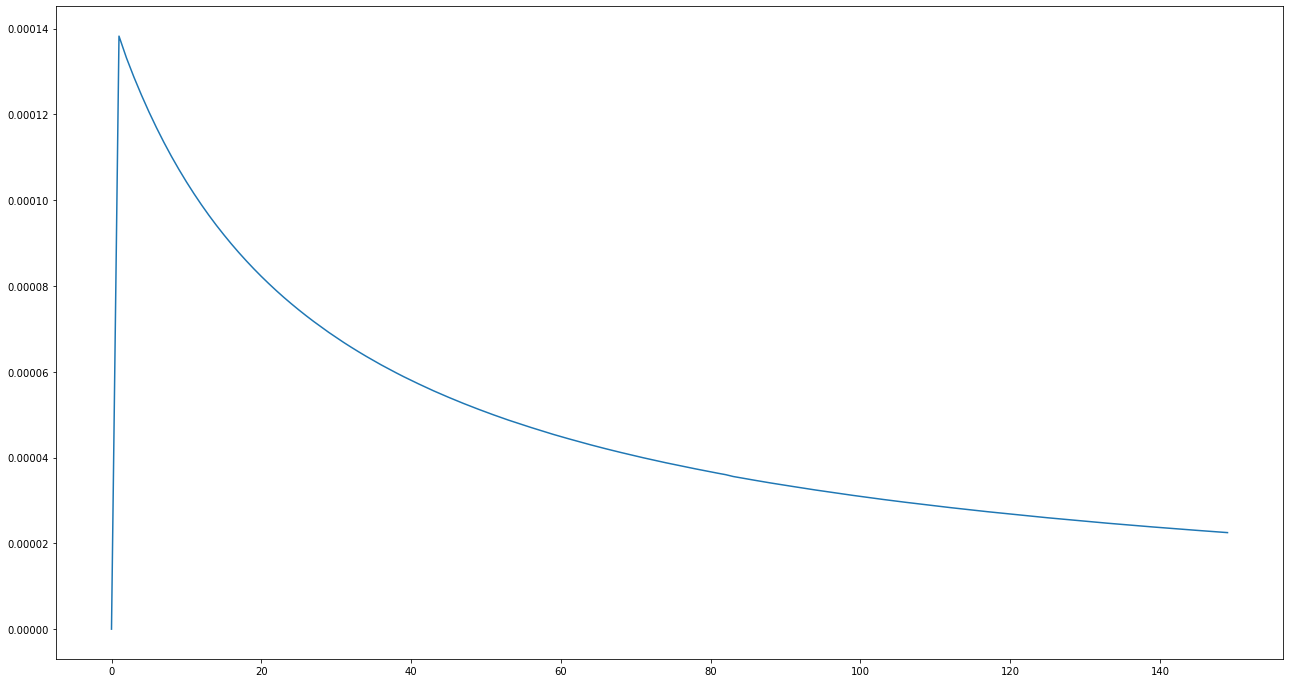

In [17]:
avg1 = 0
avgLossPerEpoch1 = []
for i in range(len(pltdata1)):
    avg1 = avg1 + pltdata1[i]
    if(i%780==0):
        avgLossPerEpoch1.append(avg1/780)
        avg1 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch1[0:150])  

learning rate  0.02
dev  cuda
[1,   100] loss: 0.0000004634
[1,   200] loss: 0.0000004637
[1,   300] loss: 0.0000004388
[1,   400] loss: 0.0000004292
[1,   500] loss: 0.0000004074
[1,   600] loss: 0.0000004240
[1,   700] loss: 0.0000004877
[2,   100] loss: 0.0000004624
[2,   200] loss: 0.0000004627
[2,   300] loss: 0.0000004379
[2,   400] loss: 0.0000004285
[2,   500] loss: 0.0000004064
[2,   600] loss: 0.0000004232
[2,   700] loss: 0.0000004868
[3,   100] loss: 0.0000004615
[3,   200] loss: 0.0000004617
[3,   300] loss: 0.0000004372
[3,   400] loss: 0.0000004276
[3,   500] loss: 0.0000004055
[3,   600] loss: 0.0000004222
[3,   700] loss: 0.0000004857
[4,   100] loss: 0.0000004607
[4,   200] loss: 0.0000004609
[4,   300] loss: 0.0000004365
[4,   400] loss: 0.0000004267
[4,   500] loss: 0.0000004048
[4,   600] loss: 0.0000004213
[4,   700] loss: 0.0000004849
[5,   100] loss: 0.0000004599
[5,   200] loss: 0.0000004599
[5,   300] loss: 0.0000004355
[5,   400] loss: 0.0000004260
[5,   500]

[39,   100] loss: 0.0000004312
[39,   200] loss: 0.0000004311
[39,   300] loss: 0.0000004084
[39,   400] loss: 0.0000004000
[39,   500] loss: 0.0000003794
[39,   600] loss: 0.0000003943
[39,   700] loss: 0.0000004532
[40,   100] loss: 0.0000004304
[40,   200] loss: 0.0000004304
[40,   300] loss: 0.0000004076
[40,   400] loss: 0.0000003993
[40,   500] loss: 0.0000003787
[40,   600] loss: 0.0000003936
[40,   700] loss: 0.0000004522
[41,   100] loss: 0.0000004297
[41,   200] loss: 0.0000004293
[41,   300] loss: 0.0000004067
[41,   400] loss: 0.0000003983
[41,   500] loss: 0.0000003781
[41,   600] loss: 0.0000003929
[41,   700] loss: 0.0000004514
[42,   100] loss: 0.0000004289
[42,   200] loss: 0.0000004285
[42,   300] loss: 0.0000004060
[42,   400] loss: 0.0000003977
[42,   500] loss: 0.0000003773
[42,   600] loss: 0.0000003920
[42,   700] loss: 0.0000004507
[43,   100] loss: 0.0000004281
[43,   200] loss: 0.0000004275
[43,   300] loss: 0.0000004051
[43,   400] loss: 0.0000003970
[43,   5

[76,   700] loss: 0.0000004242
[77,   100] loss: 0.0000004040
[77,   200] loss: 0.0000004031
[77,   300] loss: 0.0000003816
[77,   400] loss: 0.0000003749
[77,   500] loss: 0.0000003555
[77,   600] loss: 0.0000003694
[77,   700] loss: 0.0000004234
[78,   100] loss: 0.0000004034
[78,   200] loss: 0.0000004025
[78,   300] loss: 0.0000003809
[78,   400] loss: 0.0000003742
[78,   500] loss: 0.0000003548
[78,   600] loss: 0.0000003689
[78,   700] loss: 0.0000004227
[79,   100] loss: 0.0000004027
[79,   200] loss: 0.0000004017
[79,   300] loss: 0.0000003804
[79,   400] loss: 0.0000003736
[79,   500] loss: 0.0000003541
[79,   600] loss: 0.0000003682
[79,   700] loss: 0.0000004221
[80,   100] loss: 0.0000004021
[80,   200] loss: 0.0000004009
[80,   300] loss: 0.0000003797
[80,   400] loss: 0.0000003730
[80,   500] loss: 0.0000003536
[80,   600] loss: 0.0000003676
[80,   700] loss: 0.0000004212
[81,   100] loss: 0.0000004015
[81,   200] loss: 0.0000004002
[81,   300] loss: 0.0000003790
[81,   4

[114,   300] loss: 0.0000003597
[114,   400] loss: 0.0000003535
[114,   500] loss: 0.0000003353
[114,   600] loss: 0.0000003480
[114,   700] loss: 0.0000003985
[115,   100] loss: 0.0000003799
[115,   200] loss: 0.0000003789
[115,   300] loss: 0.0000003590
[115,   400] loss: 0.0000003531
[115,   500] loss: 0.0000003350
[115,   600] loss: 0.0000003475
[115,   700] loss: 0.0000003978
[116,   100] loss: 0.0000003792
[116,   200] loss: 0.0000003783
[116,   300] loss: 0.0000003584
[116,   400] loss: 0.0000003525
[116,   500] loss: 0.0000003344
[116,   600] loss: 0.0000003470
[116,   700] loss: 0.0000003970
[117,   100] loss: 0.0000003788
[117,   200] loss: 0.0000003779
[117,   300] loss: 0.0000003579
[117,   400] loss: 0.0000003521
[117,   500] loss: 0.0000003339
[117,   600] loss: 0.0000003465
[117,   700] loss: 0.0000003964
[118,   100] loss: 0.0000003783
[118,   200] loss: 0.0000003774
[118,   300] loss: 0.0000003573
[118,   400] loss: 0.0000003517
[118,   500] loss: 0.0000003334
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 85.71 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.09 %


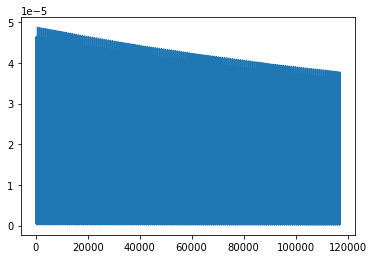

In [18]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.02)
pltdata2 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata2)

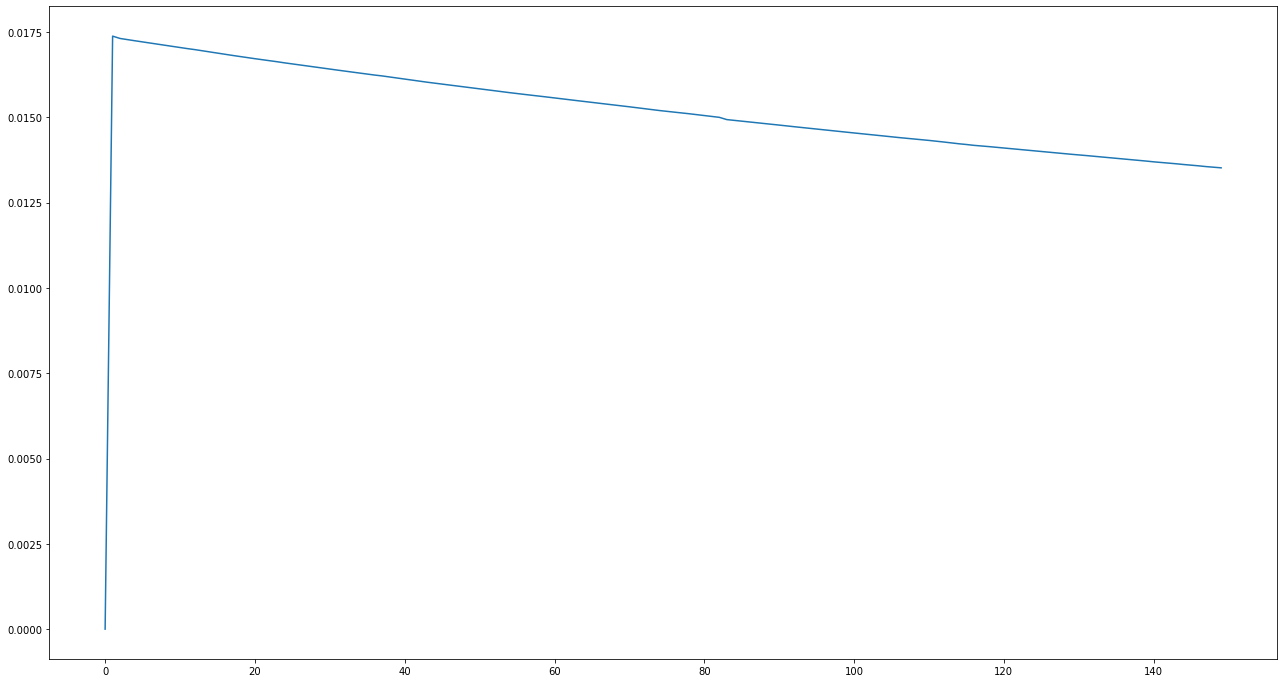

In [19]:
avg2 = 0
avgLossPerEpoch2 = []
for i in range(len(pltdata2)):
    avg2 = avg2 + pltdata2[i]
    if(i%780==0):
        avgLossPerEpoch2.append(avg2)
        avg2 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch2[0:150])       

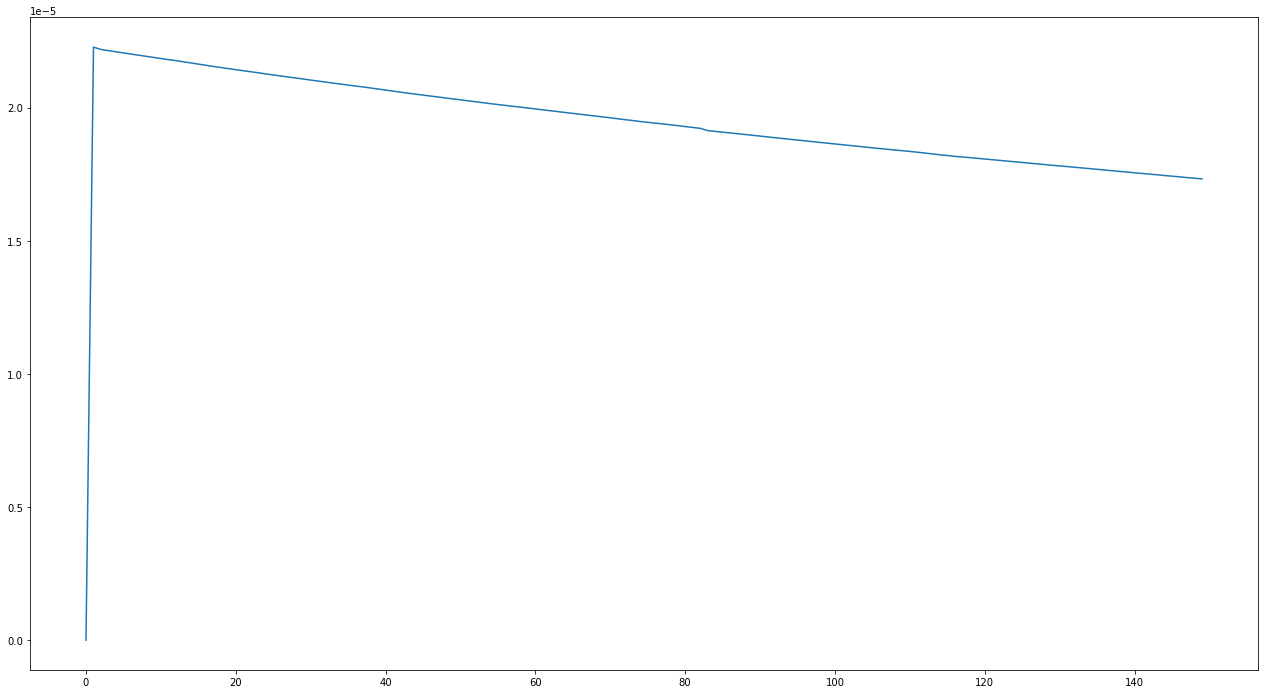

In [20]:
avg2 = 0
avgLossPerEpoch2 = []
for i in range(len(pltdata2)):
    avg2 = avg2 + pltdata2[i]
    if(i%780==0):
        avgLossPerEpoch2.append(avg2/780)
        avg2 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch2[0:150])  

learning rate  0.03
dev  cuda
[1,   100] loss: 0.0000003598
[1,   200] loss: 0.0000003590
[1,   300] loss: 0.0000003405
[1,   400] loss: 0.0000003355
[1,   500] loss: 0.0000003181
[1,   600] loss: 0.0000003292
[1,   700] loss: 0.0000003770
[2,   100] loss: 0.0000003589
[2,   200] loss: 0.0000003581
[2,   300] loss: 0.0000003396
[2,   400] loss: 0.0000003348
[2,   500] loss: 0.0000003174
[2,   600] loss: 0.0000003285
[2,   700] loss: 0.0000003760
[3,   100] loss: 0.0000003582
[3,   200] loss: 0.0000003571
[3,   300] loss: 0.0000003386
[3,   400] loss: 0.0000003339
[3,   500] loss: 0.0000003163
[3,   600] loss: 0.0000003277
[3,   700] loss: 0.0000003753
[4,   100] loss: 0.0000003576
[4,   200] loss: 0.0000003564
[4,   300] loss: 0.0000003378
[4,   400] loss: 0.0000003333
[4,   500] loss: 0.0000003156
[4,   600] loss: 0.0000003270
[4,   700] loss: 0.0000003744
[5,   100] loss: 0.0000003568
[5,   200] loss: 0.0000003555
[5,   300] loss: 0.0000003373
[5,   400] loss: 0.0000003326
[5,   500]

[39,   100] loss: 0.0000003303
[39,   200] loss: 0.0000003292
[39,   300] loss: 0.0000003119
[39,   400] loss: 0.0000003079
[39,   500] loss: 0.0000002916
[39,   600] loss: 0.0000003025
[39,   700] loss: 0.0000003461
[40,   100] loss: 0.0000003299
[40,   200] loss: 0.0000003284
[40,   300] loss: 0.0000003113
[40,   400] loss: 0.0000003073
[40,   500] loss: 0.0000002911
[40,   600] loss: 0.0000003018
[40,   700] loss: 0.0000003455
[41,   100] loss: 0.0000003292
[41,   200] loss: 0.0000003277
[41,   300] loss: 0.0000003107
[41,   400] loss: 0.0000003068
[41,   500] loss: 0.0000002904
[41,   600] loss: 0.0000003012
[41,   700] loss: 0.0000003447
[42,   100] loss: 0.0000003286
[42,   200] loss: 0.0000003270
[42,   300] loss: 0.0000003099
[42,   400] loss: 0.0000003060
[42,   500] loss: 0.0000002898
[42,   600] loss: 0.0000003006
[42,   700] loss: 0.0000003439
[43,   100] loss: 0.0000003279
[43,   200] loss: 0.0000003263
[43,   300] loss: 0.0000003092
[43,   400] loss: 0.0000003053
[43,   5

[76,   700] loss: 0.0000003204
[77,   100] loss: 0.0000003057
[77,   200] loss: 0.0000003039
[77,   300] loss: 0.0000002885
[77,   400] loss: 0.0000002857
[77,   500] loss: 0.0000002702
[77,   600] loss: 0.0000002799
[77,   700] loss: 0.0000003197
[78,   100] loss: 0.0000003052
[78,   200] loss: 0.0000003033
[78,   300] loss: 0.0000002879
[78,   400] loss: 0.0000002851
[78,   500] loss: 0.0000002697
[78,   600] loss: 0.0000002793
[78,   700] loss: 0.0000003191
[79,   100] loss: 0.0000003045
[79,   200] loss: 0.0000003028
[79,   300] loss: 0.0000002874
[79,   400] loss: 0.0000002846
[79,   500] loss: 0.0000002690
[79,   600] loss: 0.0000002786
[79,   700] loss: 0.0000003186
[80,   100] loss: 0.0000003039
[80,   200] loss: 0.0000003022
[80,   300] loss: 0.0000002868
[80,   400] loss: 0.0000002840
[80,   500] loss: 0.0000002685
[80,   600] loss: 0.0000002779
[80,   700] loss: 0.0000003179
[81,   100] loss: 0.0000003034
[81,   200] loss: 0.0000003017
[81,   300] loss: 0.0000002862
[81,   4

[114,   300] loss: 0.0000002691
[114,   400] loss: 0.0000002664
[114,   500] loss: 0.0000002521
[114,   600] loss: 0.0000002606
[114,   700] loss: 0.0000002980
[115,   100] loss: 0.0000002846
[115,   200] loss: 0.0000002833
[115,   300] loss: 0.0000002685
[115,   400] loss: 0.0000002660
[115,   500] loss: 0.0000002517
[115,   600] loss: 0.0000002602
[115,   700] loss: 0.0000002975
[116,   100] loss: 0.0000002843
[116,   200] loss: 0.0000002827
[116,   300] loss: 0.0000002680
[116,   400] loss: 0.0000002654
[116,   500] loss: 0.0000002513
[116,   600] loss: 0.0000002597
[116,   700] loss: 0.0000002971
[117,   100] loss: 0.0000002837
[117,   200] loss: 0.0000002822
[117,   300] loss: 0.0000002675
[117,   400] loss: 0.0000002649
[117,   500] loss: 0.0000002509
[117,   600] loss: 0.0000002594
[117,   700] loss: 0.0000002963
[118,   100] loss: 0.0000002833
[118,   200] loss: 0.0000002816
[118,   300] loss: 0.0000002670
[118,   400] loss: 0.0000002644
[118,   500] loss: 0.0000002505
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.11 %


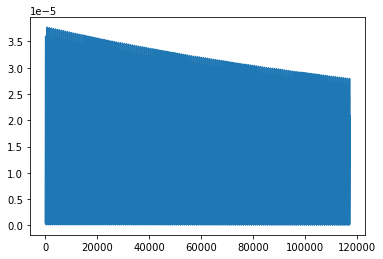

In [21]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.03)
pltdata3 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata3)

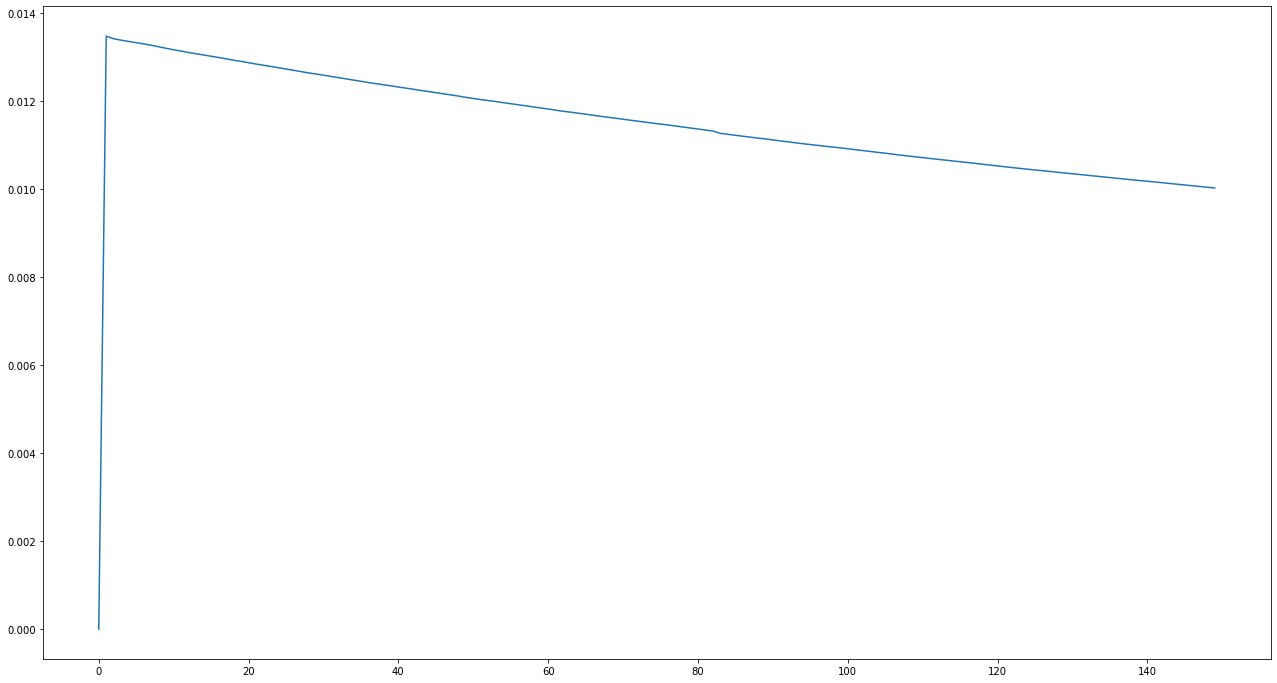

In [22]:
avg3 = 0
avgLossPerEpoch3 = []
for i in range(len(pltdata3)):
    avg3 = avg3 + pltdata3[i]
    if(i%780==0):
        avgLossPerEpoch3.append(avg3)
        avg3 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch3[0:150])       

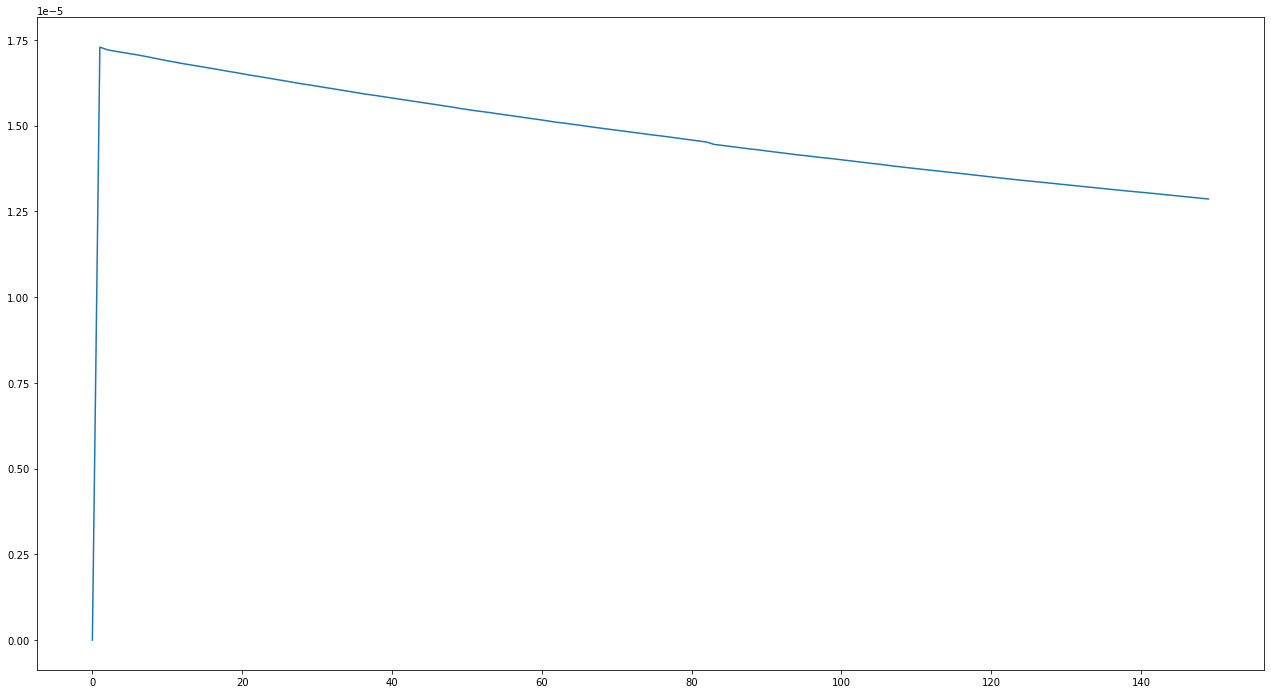

In [23]:
avg3 = 0
avgLossPerEpoch3 = []
for i in range(len(pltdata3)):
    avg3 = avg3 + pltdata3[i]
    if(i%780==0):
        avgLossPerEpoch3.append(avg3/780)
        avg3 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch3[0:150])    

learning rate  0.04
dev  cuda
[1,   100] loss: 0.0000002678
[1,   200] loss: 0.0000002661
[1,   300] loss: 0.0000002523
[1,   400] loss: 0.0000002501
[1,   500] loss: 0.0000002367
[1,   600] loss: 0.0000002448
[1,   700] loss: 0.0000002788
[2,   100] loss: 0.0000002672
[2,   200] loss: 0.0000002653
[2,   300] loss: 0.0000002515
[2,   400] loss: 0.0000002495
[2,   500] loss: 0.0000002361
[2,   600] loss: 0.0000002443
[2,   700] loss: 0.0000002781
[3,   100] loss: 0.0000002665
[3,   200] loss: 0.0000002647
[3,   300] loss: 0.0000002510
[3,   400] loss: 0.0000002489
[3,   500] loss: 0.0000002356
[3,   600] loss: 0.0000002438
[3,   700] loss: 0.0000002776
[4,   100] loss: 0.0000002659
[4,   200] loss: 0.0000002640
[4,   300] loss: 0.0000002503
[4,   400] loss: 0.0000002484
[4,   500] loss: 0.0000002351
[4,   600] loss: 0.0000002434
[4,   700] loss: 0.0000002771
[5,   100] loss: 0.0000002652
[5,   200] loss: 0.0000002634
[5,   300] loss: 0.0000002496
[5,   400] loss: 0.0000002479
[5,   500]

[39,   100] loss: 0.0000002455
[39,   200] loss: 0.0000002438
[39,   300] loss: 0.0000002309
[39,   400] loss: 0.0000002292
[39,   500] loss: 0.0000002172
[39,   600] loss: 0.0000002245
[39,   700] loss: 0.0000002558
[40,   100] loss: 0.0000002450
[40,   200] loss: 0.0000002432
[40,   300] loss: 0.0000002305
[40,   400] loss: 0.0000002287
[40,   500] loss: 0.0000002167
[40,   600] loss: 0.0000002241
[40,   700] loss: 0.0000002553
[41,   100] loss: 0.0000002445
[41,   200] loss: 0.0000002427
[41,   300] loss: 0.0000002301
[41,   400] loss: 0.0000002282
[41,   500] loss: 0.0000002164
[41,   600] loss: 0.0000002235
[41,   700] loss: 0.0000002547
[42,   100] loss: 0.0000002441
[42,   200] loss: 0.0000002423
[42,   300] loss: 0.0000002298
[42,   400] loss: 0.0000002278
[42,   500] loss: 0.0000002159
[42,   600] loss: 0.0000002232
[42,   700] loss: 0.0000002541
[43,   100] loss: 0.0000002436
[43,   200] loss: 0.0000002417
[43,   300] loss: 0.0000002293
[43,   400] loss: 0.0000002273
[43,   5

[76,   700] loss: 0.0000002371
[77,   100] loss: 0.0000002274
[77,   200] loss: 0.0000002256
[77,   300] loss: 0.0000002139
[77,   400] loss: 0.0000002125
[77,   500] loss: 0.0000002011
[77,   600] loss: 0.0000002076
[77,   700] loss: 0.0000002367
[78,   100] loss: 0.0000002269
[78,   200] loss: 0.0000002251
[78,   300] loss: 0.0000002134
[78,   400] loss: 0.0000002122
[78,   500] loss: 0.0000002007
[78,   600] loss: 0.0000002072
[78,   700] loss: 0.0000002364
[79,   100] loss: 0.0000002265
[79,   200] loss: 0.0000002245
[79,   300] loss: 0.0000002130
[79,   400] loss: 0.0000002119
[79,   500] loss: 0.0000002003
[79,   600] loss: 0.0000002068
[79,   700] loss: 0.0000002360
[80,   100] loss: 0.0000002261
[80,   200] loss: 0.0000002241
[80,   300] loss: 0.0000002127
[80,   400] loss: 0.0000002116
[80,   500] loss: 0.0000001998
[80,   600] loss: 0.0000002063
[80,   700] loss: 0.0000002354
[81,   100] loss: 0.0000002256
[81,   200] loss: 0.0000002236
[81,   300] loss: 0.0000002123
[81,   4

[114,   300] loss: 0.0000001992
[114,   400] loss: 0.0000001986
[114,   500] loss: 0.0000001878
[114,   600] loss: 0.0000001937
[114,   700] loss: 0.0000002208
[115,   100] loss: 0.0000002118
[115,   200] loss: 0.0000002101
[115,   300] loss: 0.0000001988
[115,   400] loss: 0.0000001984
[115,   500] loss: 0.0000001875
[115,   600] loss: 0.0000001935
[115,   700] loss: 0.0000002203
[116,   100] loss: 0.0000002114
[116,   200] loss: 0.0000002097
[116,   300] loss: 0.0000001983
[116,   400] loss: 0.0000001980
[116,   500] loss: 0.0000001872
[116,   600] loss: 0.0000001930
[116,   700] loss: 0.0000002197
[117,   100] loss: 0.0000002108
[117,   200] loss: 0.0000002093
[117,   300] loss: 0.0000001981
[117,   400] loss: 0.0000001978
[117,   500] loss: 0.0000001868
[117,   600] loss: 0.0000001927
[117,   700] loss: 0.0000002194
[118,   100] loss: 0.0000002103
[118,   200] loss: 0.0000002090
[118,   300] loss: 0.0000001978
[118,   400] loss: 0.0000001976
[118,   500] loss: 0.0000001865
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.08 %


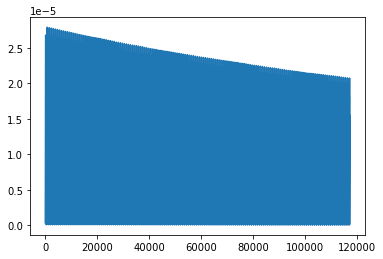

In [24]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.04)
pltdata4 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata4)

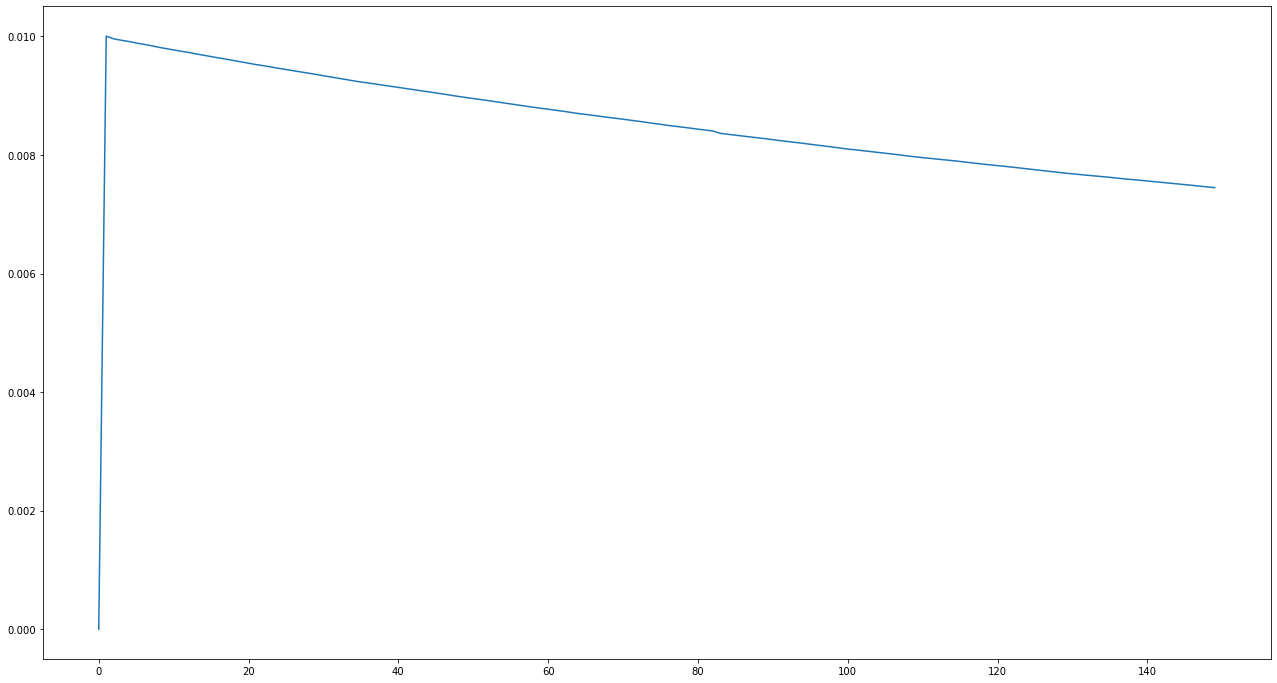

In [25]:
avg4 = 0
avgLossPerEpoch4 = []
for i in range(len(pltdata4)):
    avg4 = avg4 + pltdata4[i]
    if(i%780==0):
        avgLossPerEpoch4.append(avg4)
        avg4 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch4[0:150])       

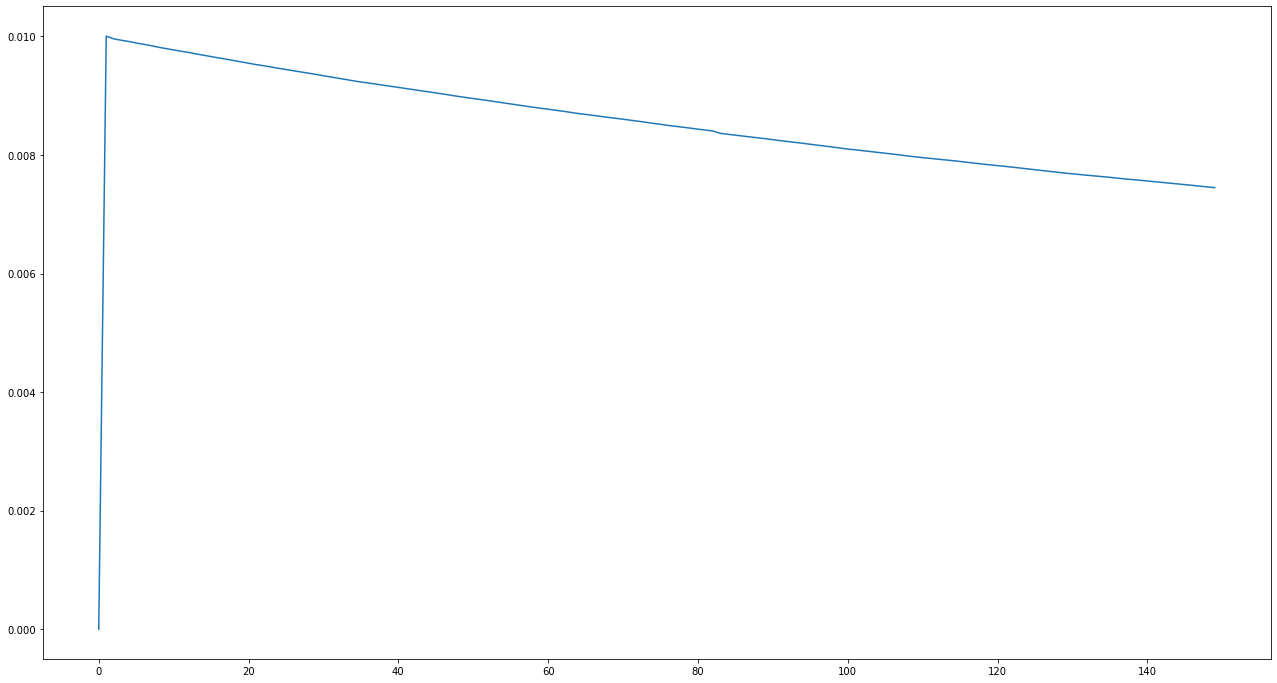

In [26]:
avg4 = 0
avgLossPerEpoch4 = []
for i in range(len(pltdata4)):
    avg4 = avg4 + pltdata4[i]
    if(i%780==0):
        avgLossPerEpoch4.append(avg4)
        avg4 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch4[0:150])       

learning rate  0.05
dev  cuda
[1,   100] loss: 0.0000001994
[1,   200] loss: 0.0000001972
[1,   300] loss: 0.0000001872
[1,   400] loss: 0.0000001863
[1,   500] loss: 0.0000001761
[1,   600] loss: 0.0000001818
[1,   700] loss: 0.0000002069
[2,   100] loss: 0.0000001991
[2,   200] loss: 0.0000001967
[2,   300] loss: 0.0000001868
[2,   400] loss: 0.0000001858
[2,   500] loss: 0.0000001758
[2,   600] loss: 0.0000001815
[2,   700] loss: 0.0000002064
[3,   100] loss: 0.0000001987
[3,   200] loss: 0.0000001963
[3,   300] loss: 0.0000001863
[3,   400] loss: 0.0000001855
[3,   500] loss: 0.0000001755
[3,   600] loss: 0.0000001811
[3,   700] loss: 0.0000002059
[4,   100] loss: 0.0000001980
[4,   200] loss: 0.0000001958
[4,   300] loss: 0.0000001858
[4,   400] loss: 0.0000001850
[4,   500] loss: 0.0000001749
[4,   600] loss: 0.0000001807
[4,   700] loss: 0.0000002054
[5,   100] loss: 0.0000001976
[5,   200] loss: 0.0000001954
[5,   300] loss: 0.0000001854
[5,   400] loss: 0.0000001844
[5,   500]

[39,   100] loss: 0.0000001844
[39,   200] loss: 0.0000001818
[39,   300] loss: 0.0000001728
[39,   400] loss: 0.0000001721
[39,   500] loss: 0.0000001627
[39,   600] loss: 0.0000001678
[39,   700] loss: 0.0000001914
[40,   100] loss: 0.0000001840
[40,   200] loss: 0.0000001815
[40,   300] loss: 0.0000001724
[40,   400] loss: 0.0000001718
[40,   500] loss: 0.0000001625
[40,   600] loss: 0.0000001675
[40,   700] loss: 0.0000001909
[41,   100] loss: 0.0000001837
[41,   200] loss: 0.0000001810
[41,   300] loss: 0.0000001720
[41,   400] loss: 0.0000001715
[41,   500] loss: 0.0000001621
[41,   600] loss: 0.0000001672
[41,   700] loss: 0.0000001905
[42,   100] loss: 0.0000001833
[42,   200] loss: 0.0000001807
[42,   300] loss: 0.0000001717
[42,   400] loss: 0.0000001711
[42,   500] loss: 0.0000001617
[42,   600] loss: 0.0000001670
[42,   700] loss: 0.0000001902
[43,   100] loss: 0.0000001830
[43,   200] loss: 0.0000001804
[43,   300] loss: 0.0000001714
[43,   400] loss: 0.0000001708
[43,   5

[76,   700] loss: 0.0000001780
[77,   100] loss: 0.0000001714
[77,   200] loss: 0.0000001694
[77,   300] loss: 0.0000001607
[77,   400] loss: 0.0000001608
[77,   500] loss: 0.0000001516
[77,   600] loss: 0.0000001564
[77,   700] loss: 0.0000001776
[78,   100] loss: 0.0000001711
[78,   200] loss: 0.0000001691
[78,   300] loss: 0.0000001603
[78,   400] loss: 0.0000001604
[78,   500] loss: 0.0000001512
[78,   600] loss: 0.0000001562
[78,   700] loss: 0.0000001773
[79,   100] loss: 0.0000001708
[79,   200] loss: 0.0000001687
[79,   300] loss: 0.0000001600
[79,   400] loss: 0.0000001601
[79,   500] loss: 0.0000001510
[79,   600] loss: 0.0000001558
[79,   700] loss: 0.0000001768
[80,   100] loss: 0.0000001705
[80,   200] loss: 0.0000001684
[80,   300] loss: 0.0000001598
[80,   400] loss: 0.0000001598
[80,   500] loss: 0.0000001507
[80,   600] loss: 0.0000001556
[80,   700] loss: 0.0000001764
[81,   100] loss: 0.0000001704
[81,   200] loss: 0.0000001680
[81,   300] loss: 0.0000001596
[81,   4

[114,   300] loss: 0.0000001507
[114,   400] loss: 0.0000001505
[114,   500] loss: 0.0000001422
[114,   600] loss: 0.0000001471
[114,   700] loss: 0.0000001665
[115,   100] loss: 0.0000001605
[115,   200] loss: 0.0000001587
[115,   300] loss: 0.0000001505
[115,   400] loss: 0.0000001502
[115,   500] loss: 0.0000001421
[115,   600] loss: 0.0000001469
[115,   700] loss: 0.0000001661
[116,   100] loss: 0.0000001602
[116,   200] loss: 0.0000001583
[116,   300] loss: 0.0000001502
[116,   400] loss: 0.0000001501
[116,   500] loss: 0.0000001419
[116,   600] loss: 0.0000001466
[116,   700] loss: 0.0000001658
[117,   100] loss: 0.0000001599
[117,   200] loss: 0.0000001580
[117,   300] loss: 0.0000001499
[117,   400] loss: 0.0000001499
[117,   500] loss: 0.0000001417
[117,   600] loss: 0.0000001463
[117,   700] loss: 0.0000001655
[118,   100] loss: 0.0000001596
[118,   200] loss: 0.0000001578
[118,   300] loss: 0.0000001497
[118,   400] loss: 0.0000001496
[118,   500] loss: 0.0000001414
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 88.89 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.08 %


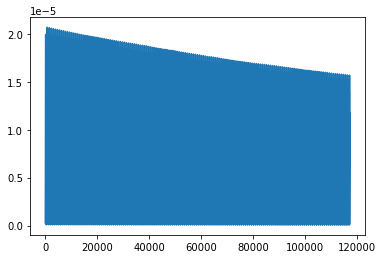

In [27]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.05)
pltdata5 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata5)

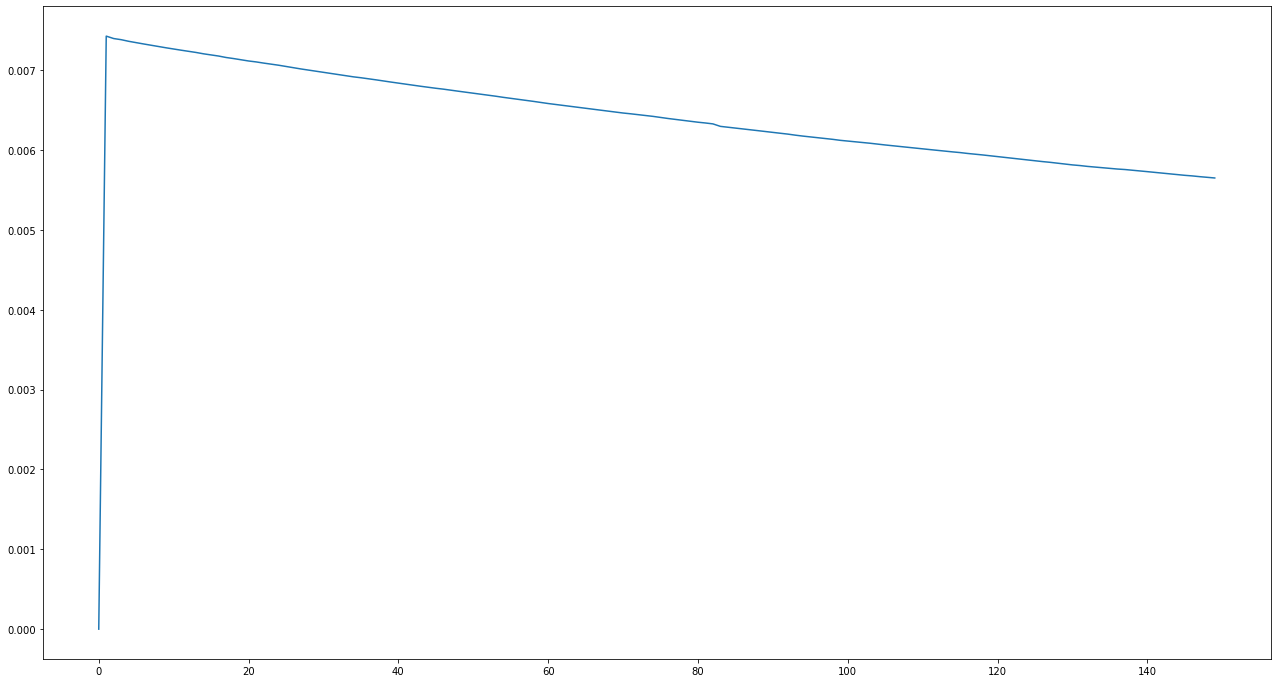

In [28]:
avg5 = 0
avgLossPerEpoch5 = []
for i in range(len(pltdata5)):
    avg5 = avg5 + pltdata5[i]
    if(i%780==0):
        avgLossPerEpoch5.append(avg5)
        avg5 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch5[0:150])       

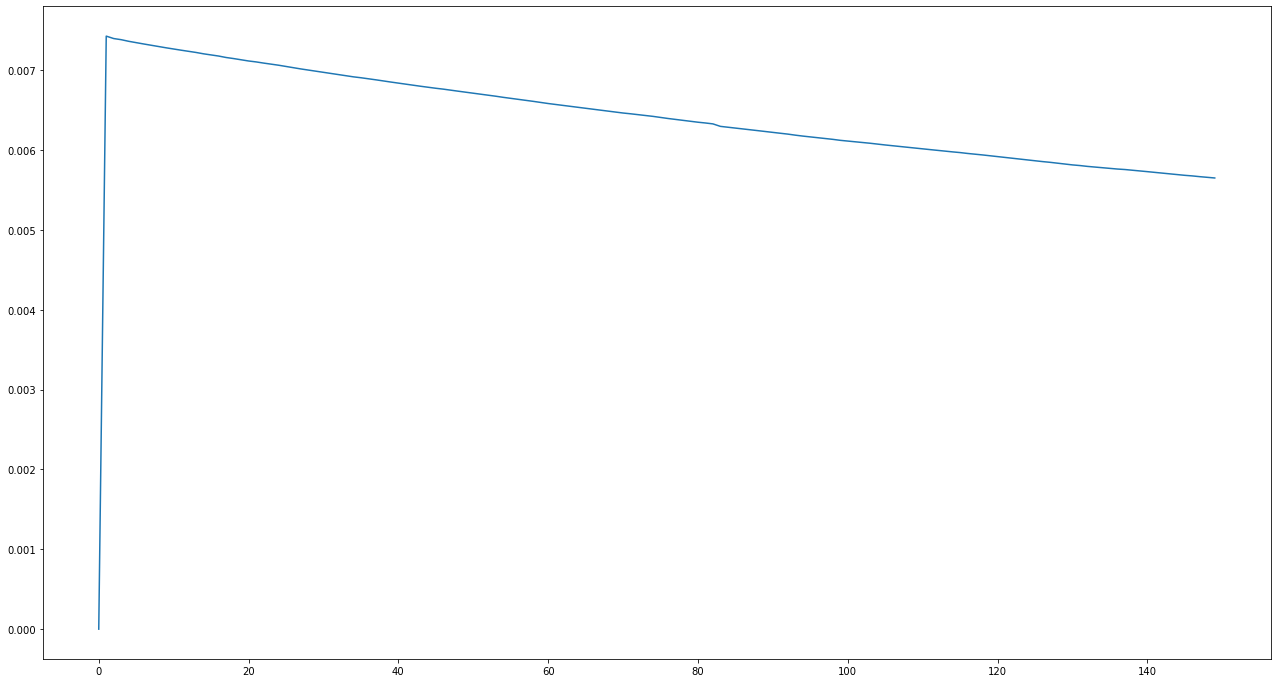

In [29]:
avg5 = 0
avgLossPerEpoch5 = []
for i in range(len(pltdata5)):
    avg5 = avg5 + pltdata5[i]
    if(i%780==0):
        avgLossPerEpoch5.append(avg5)
        avg5 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch5[0:150])       

learning rate  0.06
dev  cuda
[1,   100] loss: 0.0000001513
[1,   200] loss: 0.0000001496
[1,   300] loss: 0.0000001421
[1,   400] loss: 0.0000001416
[1,   500] loss: 0.0000001339
[1,   600] loss: 0.0000001385
[1,   700] loss: 0.0000001566
[2,   100] loss: 0.0000001509
[2,   200] loss: 0.0000001493
[2,   300] loss: 0.0000001417
[2,   400] loss: 0.0000001414
[2,   500] loss: 0.0000001337
[2,   600] loss: 0.0000001383
[2,   700] loss: 0.0000001565
[3,   100] loss: 0.0000001506
[3,   200] loss: 0.0000001490
[3,   300] loss: 0.0000001414
[3,   400] loss: 0.0000001410
[3,   500] loss: 0.0000001335
[3,   600] loss: 0.0000001380
[3,   700] loss: 0.0000001561
[4,   100] loss: 0.0000001502
[4,   200] loss: 0.0000001487
[4,   300] loss: 0.0000001412
[4,   400] loss: 0.0000001407
[4,   500] loss: 0.0000001334
[4,   600] loss: 0.0000001377
[4,   700] loss: 0.0000001559
[5,   100] loss: 0.0000001499
[5,   200] loss: 0.0000001484
[5,   300] loss: 0.0000001408
[5,   400] loss: 0.0000001404
[5,   500]

[39,   100] loss: 0.0000001406
[39,   200] loss: 0.0000001391
[39,   300] loss: 0.0000001317
[39,   400] loss: 0.0000001325
[39,   500] loss: 0.0000001248
[39,   600] loss: 0.0000001287
[39,   700] loss: 0.0000001456
[40,   100] loss: 0.0000001403
[40,   200] loss: 0.0000001388
[40,   300] loss: 0.0000001315
[40,   400] loss: 0.0000001323
[40,   500] loss: 0.0000001245
[40,   600] loss: 0.0000001285
[40,   700] loss: 0.0000001453
[41,   100] loss: 0.0000001400
[41,   200] loss: 0.0000001386
[41,   300] loss: 0.0000001313
[41,   400] loss: 0.0000001321
[41,   500] loss: 0.0000001243
[41,   600] loss: 0.0000001284
[41,   700] loss: 0.0000001450
[42,   100] loss: 0.0000001398
[42,   200] loss: 0.0000001384
[42,   300] loss: 0.0000001310
[42,   400] loss: 0.0000001318
[42,   500] loss: 0.0000001241
[42,   600] loss: 0.0000001282
[42,   700] loss: 0.0000001447
[43,   100] loss: 0.0000001394
[43,   200] loss: 0.0000001382
[43,   300] loss: 0.0000001309
[43,   400] loss: 0.0000001316
[43,   5

[76,   700] loss: 0.0000001368
[77,   100] loss: 0.0000001320
[77,   200] loss: 0.0000001302
[77,   300] loss: 0.0000001232
[77,   400] loss: 0.0000001241
[77,   500] loss: 0.0000001167
[77,   600] loss: 0.0000001206
[77,   700] loss: 0.0000001364
[78,   100] loss: 0.0000001318
[78,   200] loss: 0.0000001299
[78,   300] loss: 0.0000001230
[78,   400] loss: 0.0000001240
[78,   500] loss: 0.0000001164
[78,   600] loss: 0.0000001203
[78,   700] loss: 0.0000001363
[79,   100] loss: 0.0000001317
[79,   200] loss: 0.0000001297
[79,   300] loss: 0.0000001228
[79,   400] loss: 0.0000001239
[79,   500] loss: 0.0000001162
[79,   600] loss: 0.0000001201
[79,   700] loss: 0.0000001360
[80,   100] loss: 0.0000001314
[80,   200] loss: 0.0000001296
[80,   300] loss: 0.0000001227
[80,   400] loss: 0.0000001237
[80,   500] loss: 0.0000001160
[80,   600] loss: 0.0000001199
[80,   700] loss: 0.0000001358
[81,   100] loss: 0.0000001311
[81,   200] loss: 0.0000001292
[81,   300] loss: 0.0000001225
[81,   4

[114,   300] loss: 0.0000001163
[114,   400] loss: 0.0000001172
[114,   500] loss: 0.0000001103
[114,   600] loss: 0.0000001142
[114,   700] loss: 0.0000001284
[115,   100] loss: 0.0000001239
[115,   200] loss: 0.0000001229
[115,   300] loss: 0.0000001161
[115,   400] loss: 0.0000001171
[115,   500] loss: 0.0000001102
[115,   600] loss: 0.0000001140
[115,   700] loss: 0.0000001282
[116,   100] loss: 0.0000001238
[116,   200] loss: 0.0000001227
[116,   300] loss: 0.0000001159
[116,   400] loss: 0.0000001168
[116,   500] loss: 0.0000001100
[116,   600] loss: 0.0000001137
[116,   700] loss: 0.0000001280
[117,   100] loss: 0.0000001236
[117,   200] loss: 0.0000001225
[117,   300] loss: 0.0000001157
[117,   400] loss: 0.0000001167
[117,   500] loss: 0.0000001099
[117,   600] loss: 0.0000001136
[117,   700] loss: 0.0000001278
[118,   100] loss: 0.0000001234
[118,   200] loss: 0.0000001223
[118,   300] loss: 0.0000001154
[118,   400] loss: 0.0000001165
[118,   500] loss: 0.0000001098
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 92.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 88.89 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.08 %


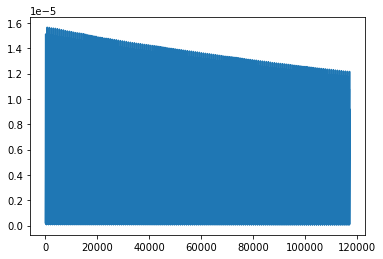

In [30]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.06)
pltdata6 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata6)

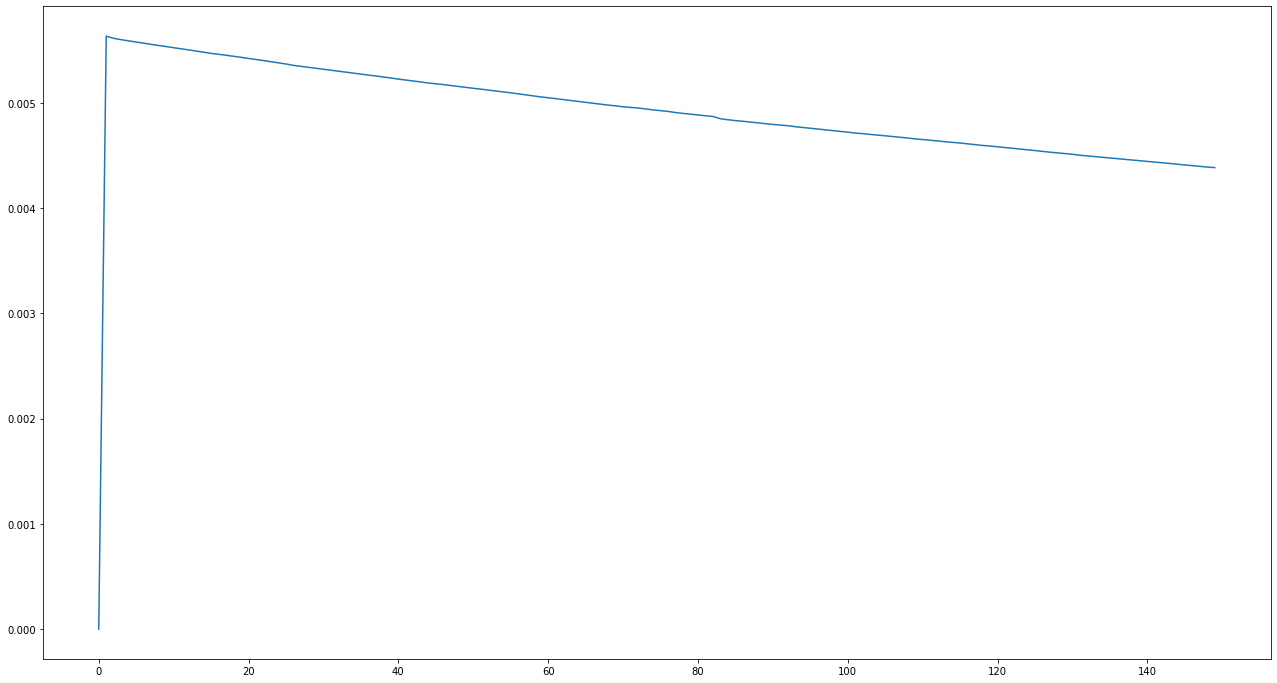

In [31]:
avg6 = 0
avgLossPerEpoch6 = []
for i in range(len(pltdata6)):
    avg6 = avg6 + pltdata6[i]
    if(i%780==0):
        avgLossPerEpoch6.append(avg6)
        avg6 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch6[0:150])       

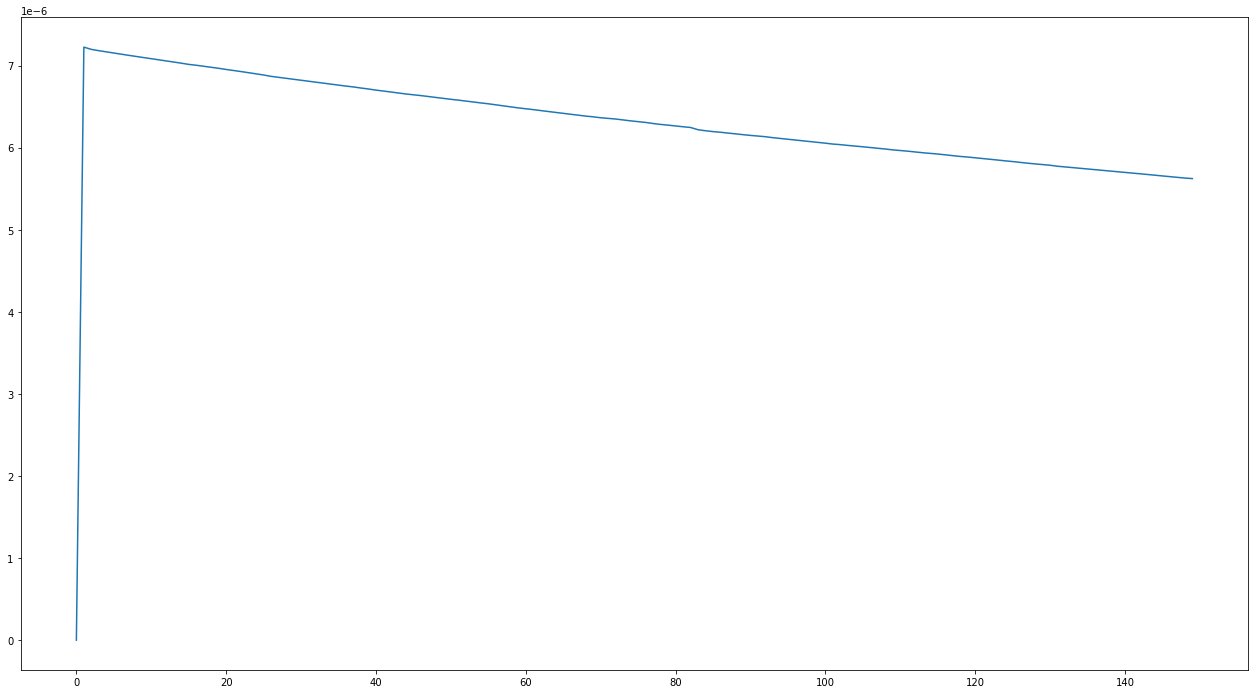

In [32]:
avg6 = 0
avgLossPerEpoch6 = []
for i in range(len(pltdata6)):
    avg6 = avg6 + pltdata6[i]
    if(i%780==0):
        avgLossPerEpoch6.append(avg6/780)
        avg6 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch6[0:150])       

learning rate  0.07
dev  cuda
[1,   100] loss: 0.0000001175
[1,   200] loss: 0.0000001160
[1,   300] loss: 0.0000001100
[1,   400] loss: 0.0000001107
[1,   500] loss: 0.0000001041
[1,   600] loss: 0.0000001077
[1,   700] loss: 0.0000001215
[2,   100] loss: 0.0000001173
[2,   200] loss: 0.0000001158
[2,   300] loss: 0.0000001098
[2,   400] loss: 0.0000001106
[2,   500] loss: 0.0000001039
[2,   600] loss: 0.0000001075
[2,   700] loss: 0.0000001213
[3,   100] loss: 0.0000001172
[3,   200] loss: 0.0000001157
[3,   300] loss: 0.0000001096
[3,   400] loss: 0.0000001103
[3,   500] loss: 0.0000001037
[3,   600] loss: 0.0000001073
[3,   700] loss: 0.0000001212
[4,   100] loss: 0.0000001170
[4,   200] loss: 0.0000001155
[4,   300] loss: 0.0000001095
[4,   400] loss: 0.0000001101
[4,   500] loss: 0.0000001036
[4,   600] loss: 0.0000001071
[4,   700] loss: 0.0000001211
[5,   100] loss: 0.0000001167
[5,   200] loss: 0.0000001154
[5,   300] loss: 0.0000001092
[5,   400] loss: 0.0000001098
[5,   500]

[39,   100] loss: 0.0000001104
[39,   200] loss: 0.0000001086
[39,   300] loss: 0.0000001037
[39,   400] loss: 0.0000001037
[39,   500] loss: 0.0000000978
[39,   600] loss: 0.0000001008
[39,   700] loss: 0.0000001143
[40,   100] loss: 0.0000001103
[40,   200] loss: 0.0000001084
[40,   300] loss: 0.0000001035
[40,   400] loss: 0.0000001036
[40,   500] loss: 0.0000000976
[40,   600] loss: 0.0000001007
[40,   700] loss: 0.0000001139
[41,   100] loss: 0.0000001101
[41,   200] loss: 0.0000001084
[41,   300] loss: 0.0000001034
[41,   400] loss: 0.0000001035
[41,   500] loss: 0.0000000975
[41,   600] loss: 0.0000001005
[41,   700] loss: 0.0000001138
[42,   100] loss: 0.0000001100
[42,   200] loss: 0.0000001082
[42,   300] loss: 0.0000001032
[42,   400] loss: 0.0000001033
[42,   500] loss: 0.0000000973
[42,   600] loss: 0.0000001002
[42,   700] loss: 0.0000001136
[43,   100] loss: 0.0000001097
[43,   200] loss: 0.0000001079
[43,   300] loss: 0.0000001029
[43,   400] loss: 0.0000001031
[43,   5

[76,   700] loss: 0.0000001078
[77,   100] loss: 0.0000001041
[77,   200] loss: 0.0000001027
[77,   300] loss: 0.0000000973
[77,   400] loss: 0.0000000978
[77,   500] loss: 0.0000000920
[77,   600] loss: 0.0000000950
[77,   700] loss: 0.0000001076
[78,   100] loss: 0.0000001038
[78,   200] loss: 0.0000001025
[78,   300] loss: 0.0000000972
[78,   400] loss: 0.0000000976
[78,   500] loss: 0.0000000918
[78,   600] loss: 0.0000000949
[78,   700] loss: 0.0000001075
[79,   100] loss: 0.0000001037
[79,   200] loss: 0.0000001023
[79,   300] loss: 0.0000000971
[79,   400] loss: 0.0000000975
[79,   500] loss: 0.0000000918
[79,   600] loss: 0.0000000948
[79,   700] loss: 0.0000001074
[80,   100] loss: 0.0000001035
[80,   200] loss: 0.0000001021
[80,   300] loss: 0.0000000970
[80,   400] loss: 0.0000000973
[80,   500] loss: 0.0000000917
[80,   600] loss: 0.0000000945
[80,   700] loss: 0.0000001072
[81,   100] loss: 0.0000001033
[81,   200] loss: 0.0000001019
[81,   300] loss: 0.0000000968
[81,   4

[114,   300] loss: 0.0000000923
[114,   400] loss: 0.0000000925
[114,   500] loss: 0.0000000874
[114,   600] loss: 0.0000000902
[114,   700] loss: 0.0000001016
[115,   100] loss: 0.0000000982
[115,   200] loss: 0.0000000968
[115,   300] loss: 0.0000000922
[115,   400] loss: 0.0000000924
[115,   500] loss: 0.0000000873
[115,   600] loss: 0.0000000900
[115,   700] loss: 0.0000001015
[116,   100] loss: 0.0000000981
[116,   200] loss: 0.0000000966
[116,   300] loss: 0.0000000921
[116,   400] loss: 0.0000000923
[116,   500] loss: 0.0000000872
[116,   600] loss: 0.0000000899
[116,   700] loss: 0.0000001013
[117,   100] loss: 0.0000000979
[117,   200] loss: 0.0000000964
[117,   300] loss: 0.0000000920
[117,   400] loss: 0.0000000920
[117,   500] loss: 0.0000000870
[117,   600] loss: 0.0000000898
[117,   700] loss: 0.0000001011
[118,   100] loss: 0.0000000978
[118,   200] loss: 0.0000000962
[118,   300] loss: 0.0000000917
[118,   400] loss: 0.0000000920
[118,   500] loss: 0.0000000869
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 92.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 87.50 %
Accuracy of horse : 88.89 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.07 %


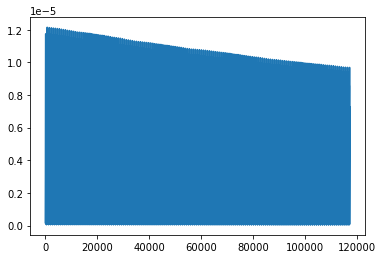

In [33]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.07)
pltdata7 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata7)

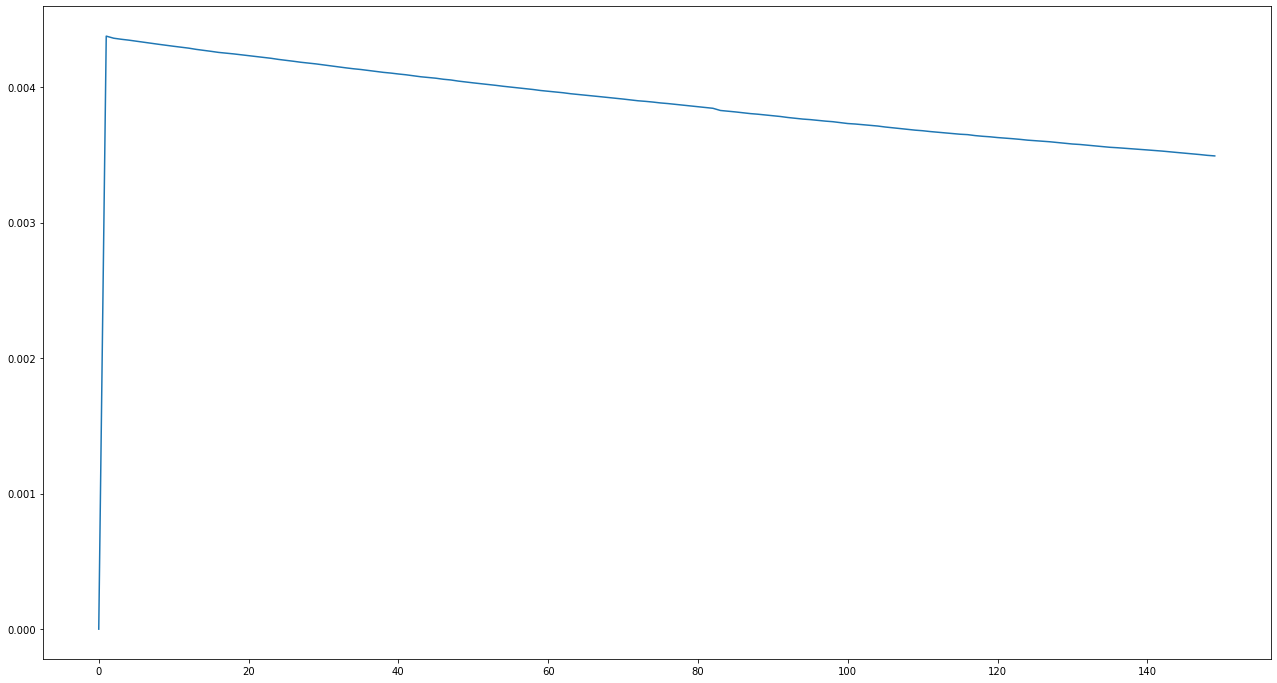

In [34]:
avg7 = 0
avgLossPerEpoch7 = []
for i in range(len(pltdata7)):
    avg7 = avg7 + pltdata7[i]
    if(i%780==0):
        avgLossPerEpoch7.append(avg7)
        avg7 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch7[0:150])       

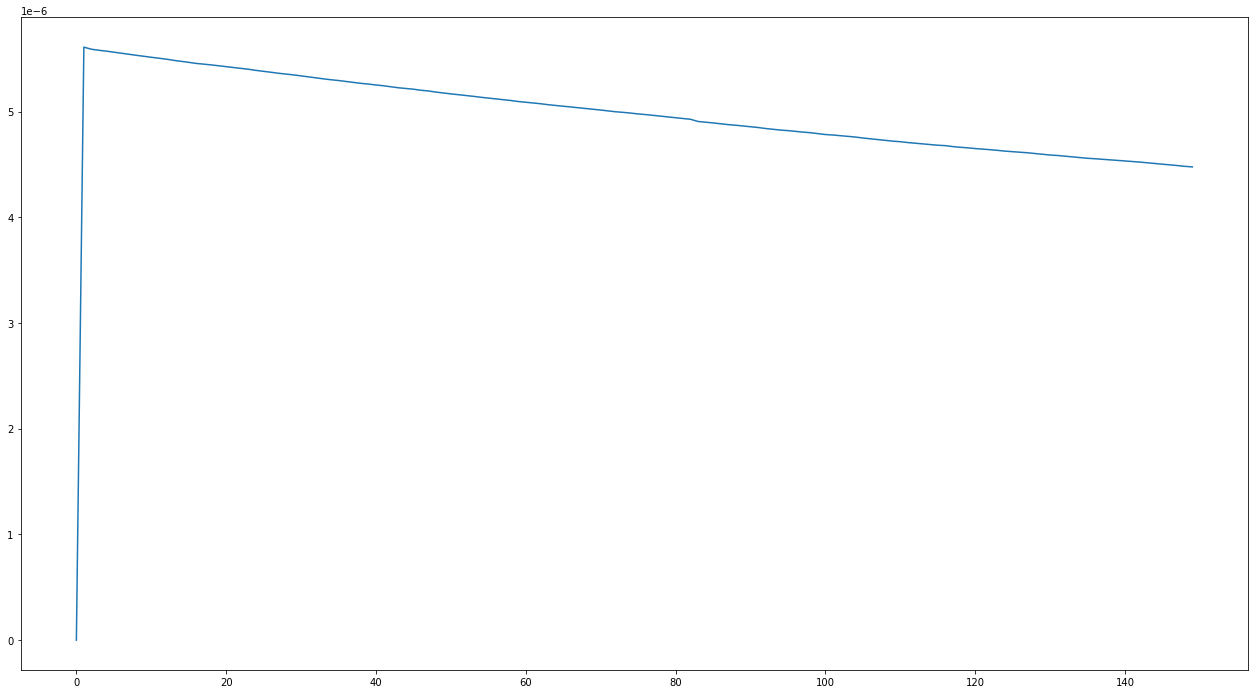

In [35]:
avg7 = 0
avgLossPerEpoch7 = []
for i in range(len(pltdata7)):
    avg7 = avg7 + pltdata7[i]
    if(i%780==0):
        avgLossPerEpoch7.append(avg7/780)
        avg7 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch7[0:150])       

learning rate  0.08
dev  cuda
[1,   100] loss: 0.0000000938
[1,   200] loss: 0.0000000921
[1,   300] loss: 0.0000000878
[1,   400] loss: 0.0000000882
[1,   500] loss: 0.0000000833
[1,   600] loss: 0.0000000857
[1,   700] loss: 0.0000000968
[2,   100] loss: 0.0000000936
[2,   200] loss: 0.0000000918
[2,   300] loss: 0.0000000877
[2,   400] loss: 0.0000000881
[2,   500] loss: 0.0000000831
[2,   600] loss: 0.0000000857
[2,   700] loss: 0.0000000966
[3,   100] loss: 0.0000000934
[3,   200] loss: 0.0000000916
[3,   300] loss: 0.0000000876
[3,   400] loss: 0.0000000880
[3,   500] loss: 0.0000000831
[3,   600] loss: 0.0000000855
[3,   700] loss: 0.0000000964
[4,   100] loss: 0.0000000933
[4,   200] loss: 0.0000000914
[4,   300] loss: 0.0000000875
[4,   400] loss: 0.0000000879
[4,   500] loss: 0.0000000830
[4,   600] loss: 0.0000000853
[4,   700] loss: 0.0000000963
[5,   100] loss: 0.0000000931
[5,   200] loss: 0.0000000912
[5,   300] loss: 0.0000000872
[5,   400] loss: 0.0000000878
[5,   500]

[39,   100] loss: 0.0000000885
[39,   200] loss: 0.0000000871
[39,   300] loss: 0.0000000826
[39,   400] loss: 0.0000000834
[39,   500] loss: 0.0000000787
[39,   600] loss: 0.0000000810
[39,   700] loss: 0.0000000912
[40,   100] loss: 0.0000000883
[40,   200] loss: 0.0000000870
[40,   300] loss: 0.0000000824
[40,   400] loss: 0.0000000833
[40,   500] loss: 0.0000000785
[40,   600] loss: 0.0000000809
[40,   700] loss: 0.0000000911
[41,   100] loss: 0.0000000882
[41,   200] loss: 0.0000000868
[41,   300] loss: 0.0000000823
[41,   400] loss: 0.0000000832
[41,   500] loss: 0.0000000784
[41,   600] loss: 0.0000000808
[41,   700] loss: 0.0000000910
[42,   100] loss: 0.0000000882
[42,   200] loss: 0.0000000867
[42,   300] loss: 0.0000000823
[42,   400] loss: 0.0000000832
[42,   500] loss: 0.0000000782
[42,   600] loss: 0.0000000807
[42,   700] loss: 0.0000000908
[43,   100] loss: 0.0000000881
[43,   200] loss: 0.0000000865
[43,   300] loss: 0.0000000820
[43,   400] loss: 0.0000000830
[43,   5

[76,   700] loss: 0.0000000865
[77,   100] loss: 0.0000000837
[77,   200] loss: 0.0000000825
[77,   300] loss: 0.0000000782
[77,   400] loss: 0.0000000793
[77,   500] loss: 0.0000000746
[77,   600] loss: 0.0000000769
[77,   700] loss: 0.0000000864
[78,   100] loss: 0.0000000836
[78,   200] loss: 0.0000000824
[78,   300] loss: 0.0000000781
[78,   400] loss: 0.0000000791
[78,   500] loss: 0.0000000745
[78,   600] loss: 0.0000000767
[78,   700] loss: 0.0000000862
[79,   100] loss: 0.0000000835
[79,   200] loss: 0.0000000822
[79,   300] loss: 0.0000000780
[79,   400] loss: 0.0000000790
[79,   500] loss: 0.0000000743
[79,   600] loss: 0.0000000766
[79,   700] loss: 0.0000000861
[80,   100] loss: 0.0000000834
[80,   200] loss: 0.0000000821
[80,   300] loss: 0.0000000780
[80,   400] loss: 0.0000000788
[80,   500] loss: 0.0000000742
[80,   600] loss: 0.0000000766
[80,   700] loss: 0.0000000860
[81,   100] loss: 0.0000000833
[81,   200] loss: 0.0000000820
[81,   300] loss: 0.0000000779
[81,   4

[114,   300] loss: 0.0000000748
[114,   400] loss: 0.0000000753
[114,   500] loss: 0.0000000711
[114,   600] loss: 0.0000000733
[114,   700] loss: 0.0000000821
[115,   100] loss: 0.0000000797
[115,   200] loss: 0.0000000785
[115,   300] loss: 0.0000000747
[115,   400] loss: 0.0000000753
[115,   500] loss: 0.0000000711
[115,   600] loss: 0.0000000733
[115,   700] loss: 0.0000000820
[116,   100] loss: 0.0000000796
[116,   200] loss: 0.0000000785
[116,   300] loss: 0.0000000746
[116,   400] loss: 0.0000000752
[116,   500] loss: 0.0000000710
[116,   600] loss: 0.0000000732
[116,   700] loss: 0.0000000819
[117,   100] loss: 0.0000000795
[117,   200] loss: 0.0000000784
[117,   300] loss: 0.0000000744
[117,   400] loss: 0.0000000751
[117,   500] loss: 0.0000000710
[117,   600] loss: 0.0000000731
[117,   700] loss: 0.0000000818
[118,   100] loss: 0.0000000794
[118,   200] loss: 0.0000000783
[118,   300] loss: 0.0000000744
[118,   400] loss: 0.0000000750
[118,   500] loss: 0.0000000709
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 92.00 %
Accuracy of  bird : 81.01 %
Accuracy of   cat : 67.12 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 87.50 %
Accuracy of horse : 88.89 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 89.74 %
Accuracy of the network on the 9984 test images: 84.10 %


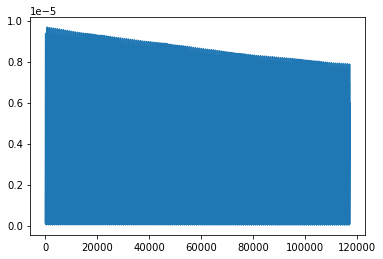

In [36]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.08)
pltdata8 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata8)

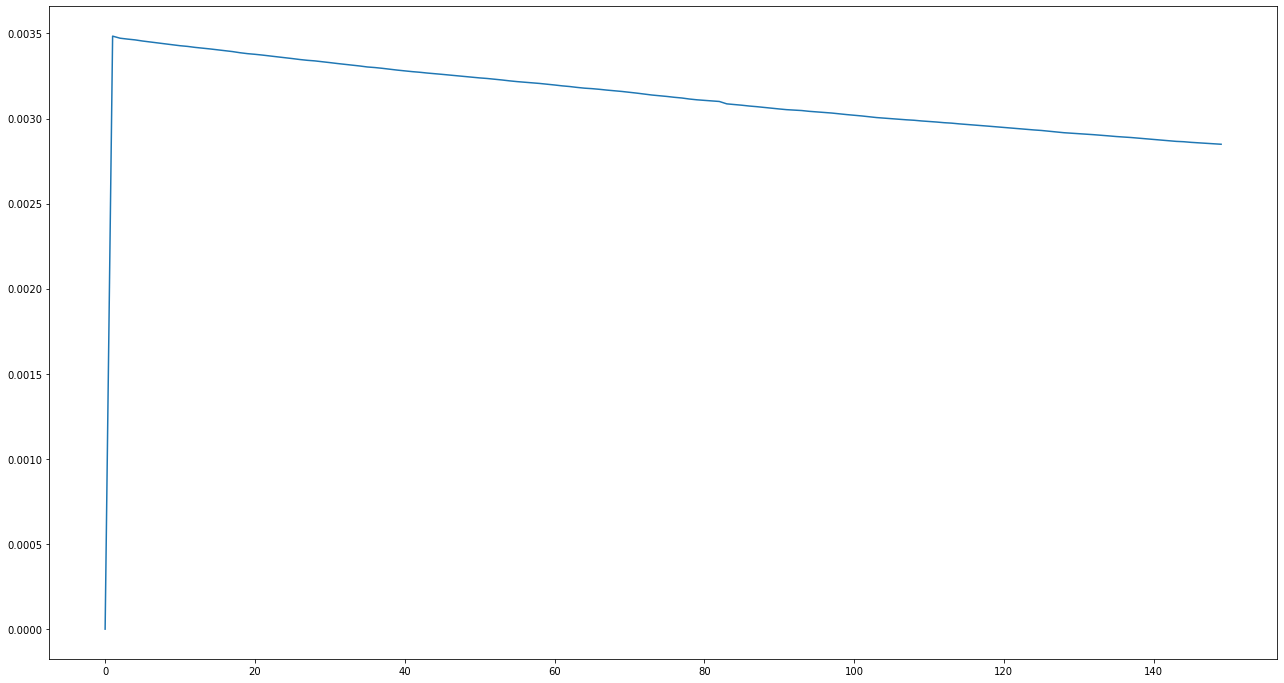

In [37]:
avg8 = 0
avgLossPerEpoch8 = []
for i in range(len(pltdata8)):
    avg8 = avg8 + pltdata8[i]
    if(i%780==0):
        avgLossPerEpoch8.append(avg8)
        avg8 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch8[0:150])       

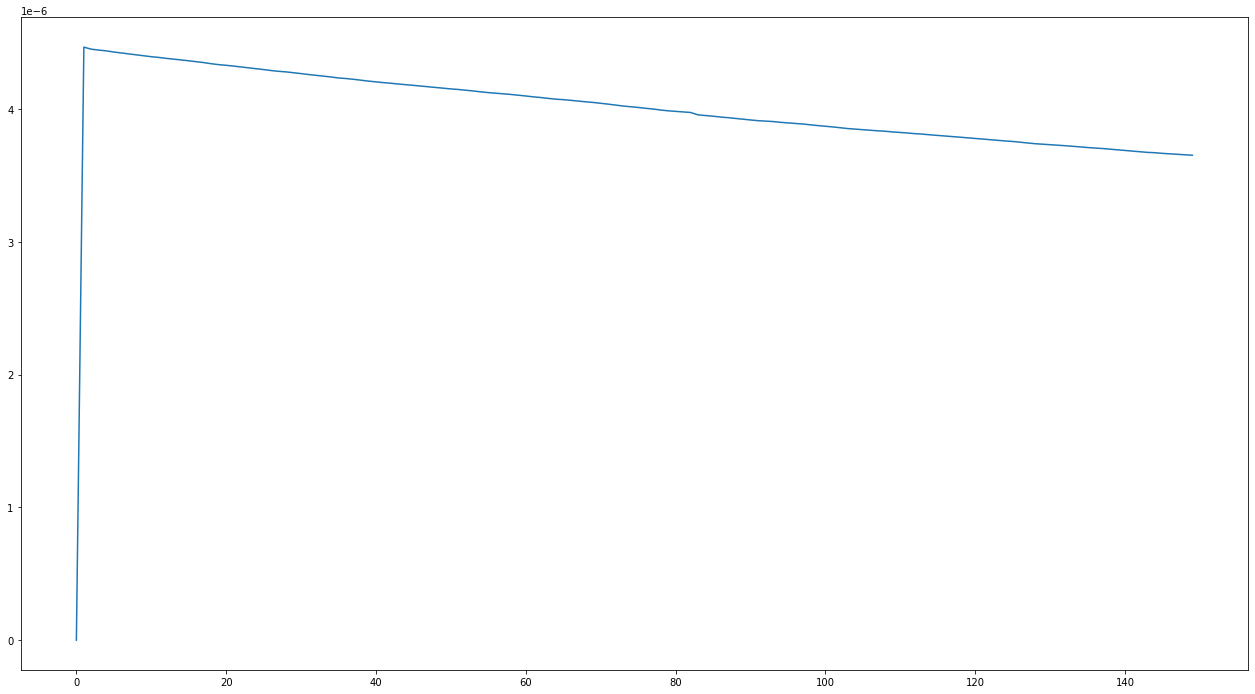

In [38]:
avg8 = 0
avgLossPerEpoch8 = []
for i in range(len(pltdata8)):
    avg8 = avg8 + pltdata8[i]
    if(i%780==0):
        avgLossPerEpoch8.append(avg8/780)
        avg8 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch8[0:150])       

In [39]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.09)
pltdata9 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata9)

learning rate  0.09
dev  cuda
[1,   100] loss: 0.0000000762
[1,   200] loss: 0.0000000752
[1,   300] loss: 0.0000000715
[1,   400] loss: 0.0000000724
[1,   500] loss: 0.0000000683
[1,   600] loss: 0.0000000698
[1,   700] loss: 0.0000000787
[2,   100] loss: 0.0000000761
[2,   200] loss: 0.0000000751
[2,   300] loss: 0.0000000714
[2,   400] loss: 0.0000000723
[2,   500] loss: 0.0000000682
[2,   600] loss: 0.0000000698
[2,   700] loss: 0.0000000785
[3,   100] loss: 0.0000000760
[3,   200] loss: 0.0000000750
[3,   300] loss: 0.0000000713
[3,   400] loss: 0.0000000723
[3,   500] loss: 0.0000000681
[3,   600] loss: 0.0000000696
[3,   700] loss: 0.0000000785
[4,   100] loss: 0.0000000759
[4,   200] loss: 0.0000000749
[4,   300] loss: 0.0000000712
[4,   400] loss: 0.0000000722
[4,   500] loss: 0.0000000680
[4,   600] loss: 0.0000000695
[4,   700] loss: 0.0000000784
[5,   100] loss: 0.0000000758
[5,   200] loss: 0.0000000747
[5,   300] loss: 0.0000000712
[5,   400] loss: 0.0000000721
[5,   500]

[39,   100] loss: 0.0000000726
[39,   200] loss: 0.0000000709
[39,   300] loss: 0.0000000680
[39,   400] loss: 0.0000000687
[39,   500] loss: 0.0000000649
[39,   600] loss: 0.0000000663
[39,   700] loss: 0.0000000746
[40,   100] loss: 0.0000000725
[40,   200] loss: 0.0000000708
[40,   300] loss: 0.0000000680
[40,   400] loss: 0.0000000686
[40,   500] loss: 0.0000000648
[40,   600] loss: 0.0000000663
[40,   700] loss: 0.0000000744
[41,   100] loss: 0.0000000724
[41,   200] loss: 0.0000000707
[41,   300] loss: 0.0000000679
[41,   400] loss: 0.0000000685
[41,   500] loss: 0.0000000646
[41,   600] loss: 0.0000000662
[41,   700] loss: 0.0000000743
[42,   100] loss: 0.0000000724
[42,   200] loss: 0.0000000707
[42,   300] loss: 0.0000000678
[42,   400] loss: 0.0000000684
[42,   500] loss: 0.0000000646
[42,   600] loss: 0.0000000661
[42,   700] loss: 0.0000000742
[43,   100] loss: 0.0000000723
[43,   200] loss: 0.0000000705
[43,   300] loss: 0.0000000677
[43,   400] loss: 0.0000000684
[43,   5

[76,   700] loss: 0.0000000712
[77,   100] loss: 0.0000000691
[77,   200] loss: 0.0000000679
[77,   300] loss: 0.0000000647
[77,   400] loss: 0.0000000652
[77,   500] loss: 0.0000000616
[77,   600] loss: 0.0000000634
[77,   700] loss: 0.0000000711
[78,   100] loss: 0.0000000690
[78,   200] loss: 0.0000000678
[78,   300] loss: 0.0000000645
[78,   400] loss: 0.0000000650
[78,   500] loss: 0.0000000615
[78,   600] loss: 0.0000000633
[78,   700] loss: 0.0000000711
[79,   100] loss: 0.0000000690
[79,   200] loss: 0.0000000677
[79,   300] loss: 0.0000000644
[79,   400] loss: 0.0000000650
[79,   500] loss: 0.0000000614
[79,   600] loss: 0.0000000632
[79,   700] loss: 0.0000000710
[80,   100] loss: 0.0000000689
[80,   200] loss: 0.0000000677
[80,   300] loss: 0.0000000644
[80,   400] loss: 0.0000000649
[80,   500] loss: 0.0000000613
[80,   600] loss: 0.0000000632
[80,   700] loss: 0.0000000709
[81,   100] loss: 0.0000000689
[81,   200] loss: 0.0000000677
[81,   300] loss: 0.0000000641
[81,   4

[114,   300] loss: 0.0000000618
[114,   400] loss: 0.0000000624
[114,   500] loss: 0.0000000590
[114,   600] loss: 0.0000000609
[114,   700] loss: 0.0000000682
[115,   100] loss: 0.0000000658
[115,   200] loss: 0.0000000649
[115,   300] loss: 0.0000000617
[115,   400] loss: 0.0000000623
[115,   500] loss: 0.0000000590
[115,   600] loss: 0.0000000608
[115,   700] loss: 0.0000000681
[116,   100] loss: 0.0000000658
[116,   200] loss: 0.0000000649
[116,   300] loss: 0.0000000617
[116,   400] loss: 0.0000000622
[116,   500] loss: 0.0000000588
[116,   600] loss: 0.0000000607
[116,   700] loss: 0.0000000681
[117,   100] loss: 0.0000000657
[117,   200] loss: 0.0000000648
[117,   300] loss: 0.0000000616
[117,   400] loss: 0.0000000620
[117,   500] loss: 0.0000000588
[117,   600] loss: 0.0000000606
[117,   700] loss: 0.0000000680
[118,   100] loss: 0.0000000656
[118,   200] loss: 0.0000000647
[118,   300] loss: 0.0000000615
[118,   400] loss: 0.0000000620
[118,   500] loss: 0.0000000587
[118,   

KeyboardInterrupt: 

In [ ]:
avg9 = 0
avgLossPerEpoch9 = []
for i in range(len(pltdata9)):
    avg9 = avg9 + pltdata9[i]
    if(i%780==0):
        avgLossPerEpoch9.append(avg9)
        avg9 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch9[0:150])       

In [ ]:
avg9 = 0
avgLossPerEpoch9 = []
for i in range(len(pltdata9)):
    avg9 = avg9 + pltdata9[i]
    if(i%780==0):
        avgLossPerEpoch9.append(avg9)
        avg9 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch9[0:150])       

learning rate  0.2
dev  cuda
[1,   100] loss: 0.0000000606
[1,   200] loss: 0.0000000584
[1,   300] loss: 0.0000000541
[1,   400] loss: 0.0000000624
[1,   500] loss: 0.0000000554
[1,   600] loss: 0.0000000596
[1,   700] loss: 0.0000000624
[2,   100] loss: 0.0000000604
[2,   200] loss: 0.0000000582
[2,   300] loss: 0.0000000539
[2,   400] loss: 0.0000000621
[2,   500] loss: 0.0000000553
[2,   600] loss: 0.0000000594
[2,   700] loss: 0.0000000622
[3,   100] loss: 0.0000000602
[3,   200] loss: 0.0000000581
[3,   300] loss: 0.0000000538
[3,   400] loss: 0.0000000620
[3,   500] loss: 0.0000000550
[3,   600] loss: 0.0000000592
[3,   700] loss: 0.0000000620
[4,   100] loss: 0.0000000601
[4,   200] loss: 0.0000000579
[4,   300] loss: 0.0000000536
[4,   400] loss: 0.0000000620
[4,   500] loss: 0.0000000548
[4,   600] loss: 0.0000000590
[4,   700] loss: 0.0000000618
[5,   100] loss: 0.0000000598
[5,   200] loss: 0.0000000578
[5,   300] loss: 0.0000000534
[5,   400] loss: 0.0000000617
[5,   500] 

[39,   100] loss: 0.0000000544
[39,   200] loss: 0.0000000528
[39,   300] loss: 0.0000000484
[39,   400] loss: 0.0000000559
[39,   500] loss: 0.0000000495
[39,   600] loss: 0.0000000536
[39,   700] loss: 0.0000000558
[40,   100] loss: 0.0000000543
[40,   200] loss: 0.0000000526
[40,   300] loss: 0.0000000484
[40,   400] loss: 0.0000000558
[40,   500] loss: 0.0000000493
[40,   600] loss: 0.0000000535
[40,   700] loss: 0.0000000557
[41,   100] loss: 0.0000000542
[41,   200] loss: 0.0000000525
[41,   300] loss: 0.0000000482
[41,   400] loss: 0.0000000556
[41,   500] loss: 0.0000000492
[41,   600] loss: 0.0000000533
[41,   700] loss: 0.0000000556
[42,   100] loss: 0.0000000540
[42,   200] loss: 0.0000000523
[42,   300] loss: 0.0000000481
[42,   400] loss: 0.0000000555
[42,   500] loss: 0.0000000491
[42,   600] loss: 0.0000000531
[42,   700] loss: 0.0000000555
[43,   100] loss: 0.0000000538
[43,   200] loss: 0.0000000521
[43,   300] loss: 0.0000000480
[43,   400] loss: 0.0000000554
[43,   5

[76,   700] loss: 0.0000000507
[77,   100] loss: 0.0000000493
[77,   200] loss: 0.0000000476
[77,   300] loss: 0.0000000442
[77,   400] loss: 0.0000000505
[77,   500] loss: 0.0000000451
[77,   600] loss: 0.0000000482
[77,   700] loss: 0.0000000506
[78,   100] loss: 0.0000000492
[78,   200] loss: 0.0000000475
[78,   300] loss: 0.0000000441
[78,   400] loss: 0.0000000504
[78,   500] loss: 0.0000000449
[78,   600] loss: 0.0000000481
[78,   700] loss: 0.0000000505
[79,   100] loss: 0.0000000491
[79,   200] loss: 0.0000000474
[79,   300] loss: 0.0000000440
[79,   400] loss: 0.0000000503
[79,   500] loss: 0.0000000447
[79,   600] loss: 0.0000000479
[79,   700] loss: 0.0000000504
[80,   100] loss: 0.0000000489
[80,   200] loss: 0.0000000472
[80,   300] loss: 0.0000000439
[80,   400] loss: 0.0000000501
[80,   500] loss: 0.0000000446
[80,   600] loss: 0.0000000479
[80,   700] loss: 0.0000000502
[81,   100] loss: 0.0000000488
[81,   200] loss: 0.0000000472
[81,   300] loss: 0.0000000438
[81,   4

[114,   300] loss: 0.0000000403
[114,   400] loss: 0.0000000463
[114,   500] loss: 0.0000000413
[114,   600] loss: 0.0000000443
[114,   700] loss: 0.0000000463
[115,   100] loss: 0.0000000450
[115,   200] loss: 0.0000000439
[115,   300] loss: 0.0000000402
[115,   400] loss: 0.0000000462
[115,   500] loss: 0.0000000412
[115,   600] loss: 0.0000000441
[115,   700] loss: 0.0000000463
[116,   100] loss: 0.0000000449
[116,   200] loss: 0.0000000439
[116,   300] loss: 0.0000000401
[116,   400] loss: 0.0000000461
[116,   500] loss: 0.0000000412
[116,   600] loss: 0.0000000440
[116,   700] loss: 0.0000000461
[117,   100] loss: 0.0000000448
[117,   200] loss: 0.0000000438
[117,   300] loss: 0.0000000400
[117,   400] loss: 0.0000000460
[117,   500] loss: 0.0000000410
[117,   600] loss: 0.0000000439
[117,   700] loss: 0.0000000460
[118,   100] loss: 0.0000000447
[118,   200] loss: 0.0000000437
[118,   300] loss: 0.0000000399
[118,   400] loss: 0.0000000458
[118,   500] loss: 0.0000000410
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.93 %


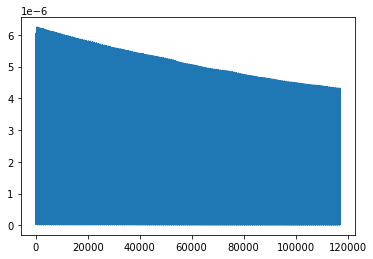

In [21]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.2)
pltdata10 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata10)

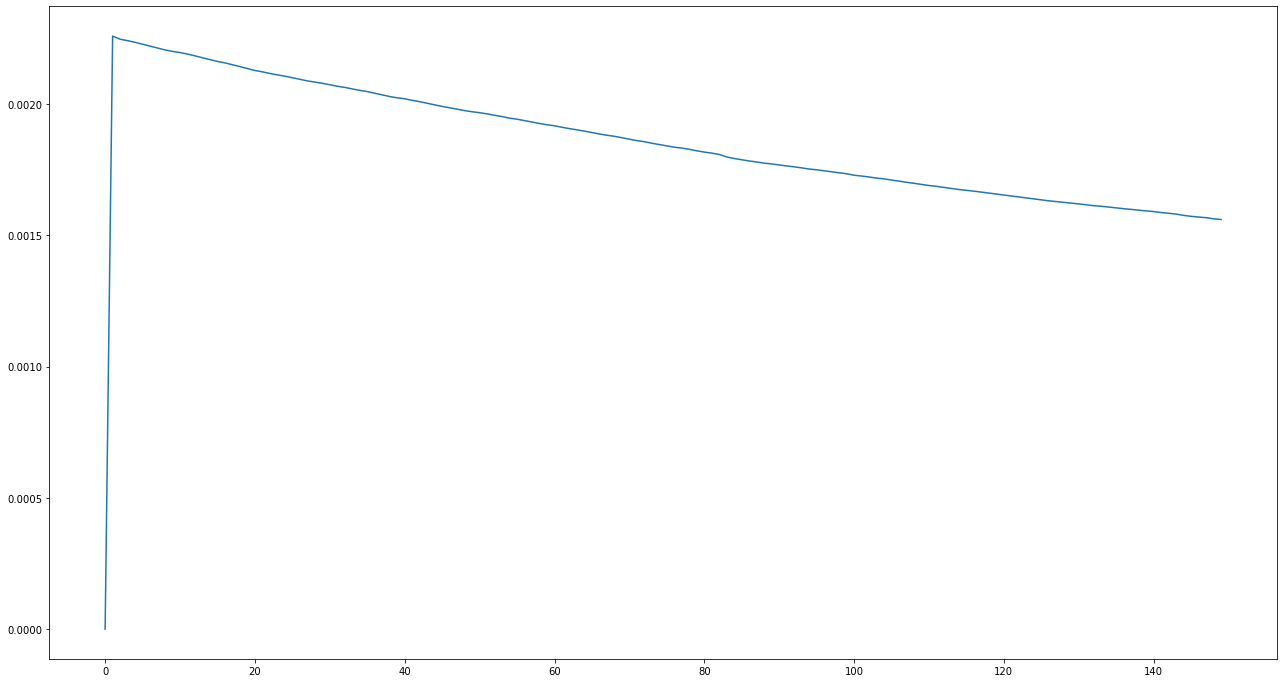

In [76]:
avg10 = 0
avgLossPerEpoch10 = []
for i in range(len(pltdata10)):
    avg10 = avg10 + pltdata10[i]
    if(i%780==0):
        avgLossPerEpoch10.append(avg10)
        avg10 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch10[0:150])       

learning rate  0.3
dev  cuda
[1,   100] loss: 0.0000000419
[1,   200] loss: 0.0000000406
[1,   300] loss: 0.0000000370
[1,   400] loss: 0.0000000431
[1,   500] loss: 0.0000000382
[1,   600] loss: 0.0000000408
[1,   700] loss: 0.0000000430
[2,   100] loss: 0.0000000417
[2,   200] loss: 0.0000000404
[2,   300] loss: 0.0000000369
[2,   400] loss: 0.0000000429
[2,   500] loss: 0.0000000380
[2,   600] loss: 0.0000000406
[2,   700] loss: 0.0000000429
[3,   100] loss: 0.0000000416
[3,   200] loss: 0.0000000403
[3,   300] loss: 0.0000000369
[3,   400] loss: 0.0000000428
[3,   500] loss: 0.0000000378
[3,   600] loss: 0.0000000405
[3,   700] loss: 0.0000000428
[4,   100] loss: 0.0000000415
[4,   200] loss: 0.0000000401
[4,   300] loss: 0.0000000368
[4,   400] loss: 0.0000000426
[4,   500] loss: 0.0000000376
[4,   600] loss: 0.0000000404
[4,   700] loss: 0.0000000427
[5,   100] loss: 0.0000000414
[5,   200] loss: 0.0000000400
[5,   300] loss: 0.0000000367
[5,   400] loss: 0.0000000425
[5,   500] 

[39,   100] loss: 0.0000000374
[39,   200] loss: 0.0000000358
[39,   300] loss: 0.0000000330
[39,   400] loss: 0.0000000381
[39,   500] loss: 0.0000000337
[39,   600] loss: 0.0000000363
[39,   700] loss: 0.0000000383
[40,   100] loss: 0.0000000373
[40,   200] loss: 0.0000000357
[40,   300] loss: 0.0000000329
[40,   400] loss: 0.0000000379
[40,   500] loss: 0.0000000336
[40,   600] loss: 0.0000000362
[40,   700] loss: 0.0000000382
[41,   100] loss: 0.0000000372
[41,   200] loss: 0.0000000356
[41,   300] loss: 0.0000000328
[41,   400] loss: 0.0000000378
[41,   500] loss: 0.0000000335
[41,   600] loss: 0.0000000361
[41,   700] loss: 0.0000000381
[42,   100] loss: 0.0000000371
[42,   200] loss: 0.0000000355
[42,   300] loss: 0.0000000328
[42,   400] loss: 0.0000000378
[42,   500] loss: 0.0000000334
[42,   600] loss: 0.0000000360
[42,   700] loss: 0.0000000381
[43,   100] loss: 0.0000000369
[43,   200] loss: 0.0000000354
[43,   300] loss: 0.0000000327
[43,   400] loss: 0.0000000376
[43,   5

[76,   700] loss: 0.0000000347
[77,   100] loss: 0.0000000336
[77,   200] loss: 0.0000000324
[77,   300] loss: 0.0000000297
[77,   400] loss: 0.0000000343
[77,   500] loss: 0.0000000302
[77,   600] loss: 0.0000000327
[77,   700] loss: 0.0000000346
[78,   100] loss: 0.0000000335
[78,   200] loss: 0.0000000323
[78,   300] loss: 0.0000000296
[78,   400] loss: 0.0000000342
[78,   500] loss: 0.0000000302
[78,   600] loss: 0.0000000327
[78,   700] loss: 0.0000000345
[79,   100] loss: 0.0000000334
[79,   200] loss: 0.0000000322
[79,   300] loss: 0.0000000295
[79,   400] loss: 0.0000000341
[79,   500] loss: 0.0000000301
[79,   600] loss: 0.0000000326
[79,   700] loss: 0.0000000343
[80,   100] loss: 0.0000000333
[80,   200] loss: 0.0000000321
[80,   300] loss: 0.0000000294
[80,   400] loss: 0.0000000340
[80,   500] loss: 0.0000000300
[80,   600] loss: 0.0000000325
[80,   700] loss: 0.0000000343
[81,   100] loss: 0.0000000332
[81,   200] loss: 0.0000000321
[81,   300] loss: 0.0000000293
[81,   4

[114,   300] loss: 0.0000000272
[114,   400] loss: 0.0000000313
[114,   500] loss: 0.0000000274
[114,   600] loss: 0.0000000300
[114,   700] loss: 0.0000000314
[115,   100] loss: 0.0000000304
[115,   200] loss: 0.0000000295
[115,   300] loss: 0.0000000272
[115,   400] loss: 0.0000000312
[115,   500] loss: 0.0000000274
[115,   600] loss: 0.0000000299
[115,   700] loss: 0.0000000313
[116,   100] loss: 0.0000000304
[116,   200] loss: 0.0000000295
[116,   300] loss: 0.0000000271
[116,   400] loss: 0.0000000311
[116,   500] loss: 0.0000000274
[116,   600] loss: 0.0000000298
[116,   700] loss: 0.0000000313
[117,   100] loss: 0.0000000303
[117,   200] loss: 0.0000000294
[117,   300] loss: 0.0000000270
[117,   400] loss: 0.0000000311
[117,   500] loss: 0.0000000273
[117,   600] loss: 0.0000000297
[117,   700] loss: 0.0000000313
[118,   100] loss: 0.0000000302
[118,   200] loss: 0.0000000293
[118,   300] loss: 0.0000000269
[118,   400] loss: 0.0000000310
[118,   500] loss: 0.0000000273
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.93 %


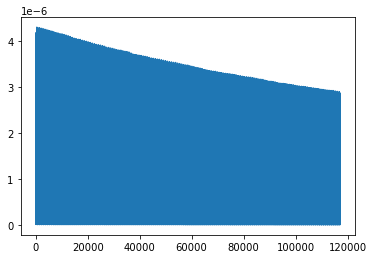

In [22]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.3)
pltdata11 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata11)

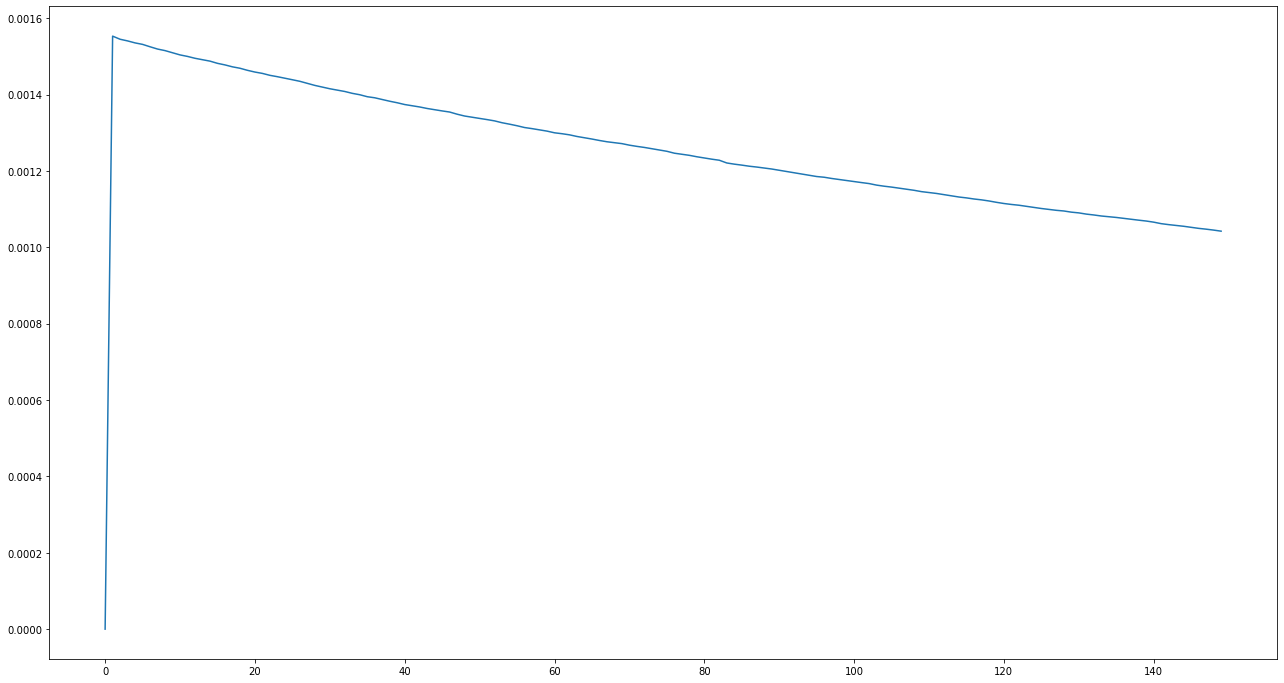

In [77]:
avg11 = 0
avgLossPerEpoch11 = []
for i in range(len(pltdata11)):
    avg11 = avg11+ pltdata11[i]
    if(i%780==0):
        avgLossPerEpoch11.append(avg11)
        avg11 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch11[0:150])       

learning rate  0.4
dev  cuda
[1,   100] loss: 0.0000000280
[1,   200] loss: 0.0000000271
[1,   300] loss: 0.0000000250
[1,   400] loss: 0.0000000290
[1,   500] loss: 0.0000000254
[1,   600] loss: 0.0000000274
[1,   700] loss: 0.0000000287
[2,   100] loss: 0.0000000279
[2,   200] loss: 0.0000000270
[2,   300] loss: 0.0000000249
[2,   400] loss: 0.0000000289
[2,   500] loss: 0.0000000254
[2,   600] loss: 0.0000000273
[2,   700] loss: 0.0000000286
[3,   100] loss: 0.0000000279
[3,   200] loss: 0.0000000269
[3,   300] loss: 0.0000000249
[3,   400] loss: 0.0000000288
[3,   500] loss: 0.0000000253
[3,   600] loss: 0.0000000273
[3,   700] loss: 0.0000000286
[4,   100] loss: 0.0000000278
[4,   200] loss: 0.0000000268
[4,   300] loss: 0.0000000248
[4,   400] loss: 0.0000000287
[4,   500] loss: 0.0000000251
[4,   600] loss: 0.0000000272
[4,   700] loss: 0.0000000285
[5,   100] loss: 0.0000000277
[5,   200] loss: 0.0000000267
[5,   300] loss: 0.0000000248
[5,   400] loss: 0.0000000286
[5,   500] 

[39,   100] loss: 0.0000000256
[39,   200] loss: 0.0000000244
[39,   300] loss: 0.0000000223
[39,   400] loss: 0.0000000262
[39,   500] loss: 0.0000000229
[39,   600] loss: 0.0000000246
[39,   700] loss: 0.0000000257
[40,   100] loss: 0.0000000256
[40,   200] loss: 0.0000000243
[40,   300] loss: 0.0000000222
[40,   400] loss: 0.0000000261
[40,   500] loss: 0.0000000228
[40,   600] loss: 0.0000000245
[40,   700] loss: 0.0000000257
[41,   100] loss: 0.0000000255
[41,   200] loss: 0.0000000242
[41,   300] loss: 0.0000000222
[41,   400] loss: 0.0000000259
[41,   500] loss: 0.0000000228
[41,   600] loss: 0.0000000245
[41,   700] loss: 0.0000000256
[42,   100] loss: 0.0000000254
[42,   200] loss: 0.0000000241
[42,   300] loss: 0.0000000221
[42,   400] loss: 0.0000000259
[42,   500] loss: 0.0000000227
[42,   600] loss: 0.0000000244
[42,   700] loss: 0.0000000256
[43,   100] loss: 0.0000000254
[43,   200] loss: 0.0000000241
[43,   300] loss: 0.0000000221
[43,   400] loss: 0.0000000258
[43,   5

[76,   700] loss: 0.0000000233
[77,   100] loss: 0.0000000233
[77,   200] loss: 0.0000000219
[77,   300] loss: 0.0000000204
[77,   400] loss: 0.0000000236
[77,   500] loss: 0.0000000205
[77,   600] loss: 0.0000000223
[77,   700] loss: 0.0000000232
[78,   100] loss: 0.0000000232
[78,   200] loss: 0.0000000219
[78,   300] loss: 0.0000000204
[78,   400] loss: 0.0000000235
[78,   500] loss: 0.0000000205
[78,   600] loss: 0.0000000222
[78,   700] loss: 0.0000000232
[79,   100] loss: 0.0000000232
[79,   200] loss: 0.0000000218
[79,   300] loss: 0.0000000204
[79,   400] loss: 0.0000000234
[79,   500] loss: 0.0000000205
[79,   600] loss: 0.0000000222
[79,   700] loss: 0.0000000232
[80,   100] loss: 0.0000000231
[80,   200] loss: 0.0000000217
[80,   300] loss: 0.0000000204
[80,   400] loss: 0.0000000234
[80,   500] loss: 0.0000000203
[80,   600] loss: 0.0000000221
[80,   700] loss: 0.0000000231
[81,   100] loss: 0.0000000230
[81,   200] loss: 0.0000000216
[81,   300] loss: 0.0000000204
[81,   4

[114,   300] loss: 0.0000000186
[114,   400] loss: 0.0000000214
[114,   500] loss: 0.0000000189
[114,   600] loss: 0.0000000201
[114,   700] loss: 0.0000000217
[115,   100] loss: 0.0000000212
[115,   200] loss: 0.0000000199
[115,   300] loss: 0.0000000186
[115,   400] loss: 0.0000000213
[115,   500] loss: 0.0000000189
[115,   600] loss: 0.0000000201
[115,   700] loss: 0.0000000217
[116,   100] loss: 0.0000000211
[116,   200] loss: 0.0000000199
[116,   300] loss: 0.0000000185
[116,   400] loss: 0.0000000213
[116,   500] loss: 0.0000000189
[116,   600] loss: 0.0000000200
[116,   700] loss: 0.0000000216
[117,   100] loss: 0.0000000210
[117,   200] loss: 0.0000000199
[117,   300] loss: 0.0000000185
[117,   400] loss: 0.0000000213
[117,   500] loss: 0.0000000188
[117,   600] loss: 0.0000000200
[117,   700] loss: 0.0000000216
[118,   100] loss: 0.0000000210
[118,   200] loss: 0.0000000199
[118,   300] loss: 0.0000000184
[118,   400] loss: 0.0000000212
[118,   500] loss: 0.0000000188
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.96 %


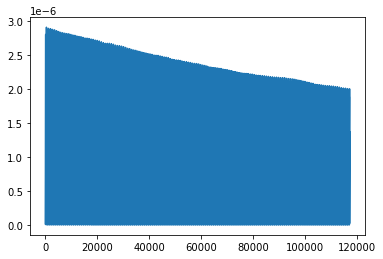

In [23]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.4)
pltdata12 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata12)

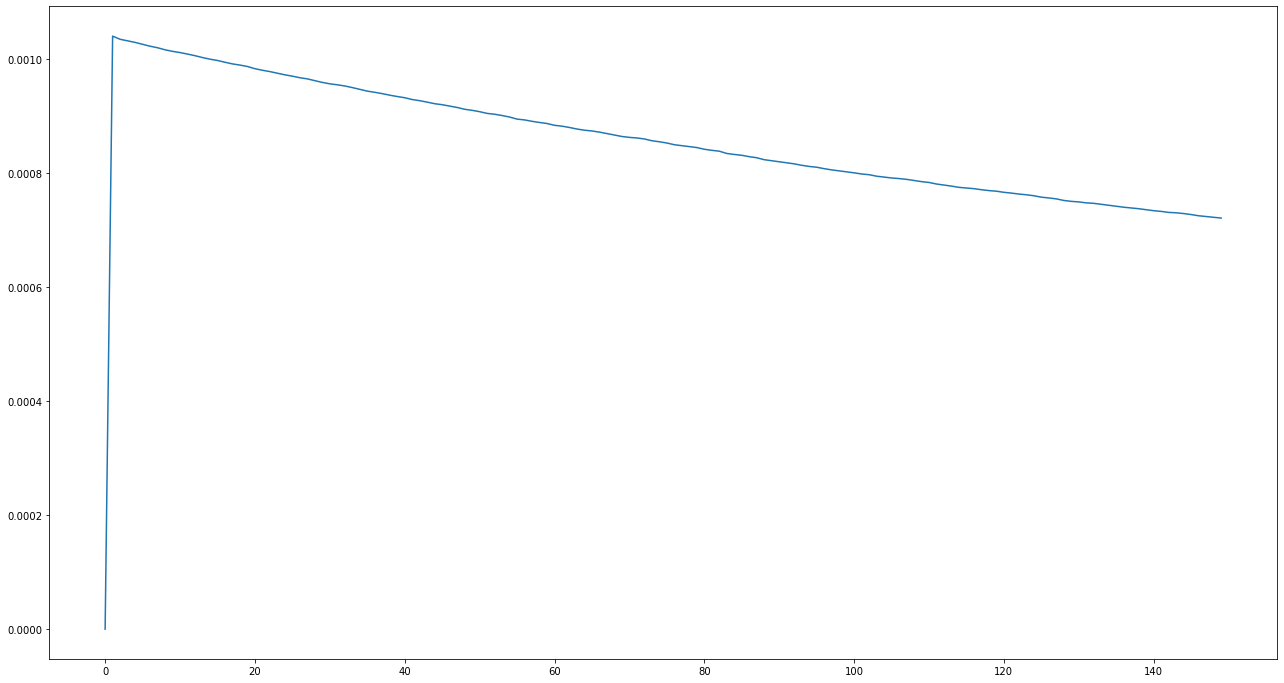

In [79]:
avg12 = 0
avgLossPerEpoch12 = []
for i in range(len(pltdata12)):
    avg12 = avg12 + pltdata12[i]
    if(i%780==0):
        avgLossPerEpoch12.append(avg12)
        avg12 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch12[0:150])       

learning rate  0.5
dev  cuda
[1,   100] loss: 0.0000000194
[1,   200] loss: 0.0000000186
[1,   300] loss: 0.0000000170
[1,   400] loss: 0.0000000198
[1,   500] loss: 0.0000000176
[1,   600] loss: 0.0000000188
[1,   700] loss: 0.0000000199
[2,   100] loss: 0.0000000194
[2,   200] loss: 0.0000000186
[2,   300] loss: 0.0000000170
[2,   400] loss: 0.0000000198
[2,   500] loss: 0.0000000175
[2,   600] loss: 0.0000000187
[2,   700] loss: 0.0000000199
[3,   100] loss: 0.0000000194
[3,   200] loss: 0.0000000185
[3,   300] loss: 0.0000000170
[3,   400] loss: 0.0000000197
[3,   500] loss: 0.0000000175
[3,   600] loss: 0.0000000186
[3,   700] loss: 0.0000000199
[4,   100] loss: 0.0000000194
[4,   200] loss: 0.0000000185
[4,   300] loss: 0.0000000169
[4,   400] loss: 0.0000000197
[4,   500] loss: 0.0000000174
[4,   600] loss: 0.0000000186
[4,   700] loss: 0.0000000198
[5,   100] loss: 0.0000000194
[5,   200] loss: 0.0000000184
[5,   300] loss: 0.0000000169
[5,   400] loss: 0.0000000197
[5,   500] 

[39,   100] loss: 0.0000000177
[39,   200] loss: 0.0000000169
[39,   300] loss: 0.0000000152
[39,   400] loss: 0.0000000183
[39,   500] loss: 0.0000000159
[39,   600] loss: 0.0000000168
[39,   700] loss: 0.0000000183
[40,   100] loss: 0.0000000176
[40,   200] loss: 0.0000000169
[40,   300] loss: 0.0000000152
[40,   400] loss: 0.0000000183
[40,   500] loss: 0.0000000159
[40,   600] loss: 0.0000000168
[40,   700] loss: 0.0000000183
[41,   100] loss: 0.0000000176
[41,   200] loss: 0.0000000168
[41,   300] loss: 0.0000000151
[41,   400] loss: 0.0000000182
[41,   500] loss: 0.0000000159
[41,   600] loss: 0.0000000167
[41,   700] loss: 0.0000000183
[42,   100] loss: 0.0000000175
[42,   200] loss: 0.0000000168
[42,   300] loss: 0.0000000150
[42,   400] loss: 0.0000000182
[42,   500] loss: 0.0000000159
[42,   600] loss: 0.0000000167
[42,   700] loss: 0.0000000182
[43,   100] loss: 0.0000000175
[43,   200] loss: 0.0000000168
[43,   300] loss: 0.0000000150
[43,   400] loss: 0.0000000181
[43,   5

[76,   700] loss: 0.0000000170
[77,   100] loss: 0.0000000163
[77,   200] loss: 0.0000000154
[77,   300] loss: 0.0000000138
[77,   400] loss: 0.0000000168
[77,   500] loss: 0.0000000147
[77,   600] loss: 0.0000000151
[77,   700] loss: 0.0000000169
[78,   100] loss: 0.0000000163
[78,   200] loss: 0.0000000154
[78,   300] loss: 0.0000000138
[78,   400] loss: 0.0000000168
[78,   500] loss: 0.0000000146
[78,   600] loss: 0.0000000151
[78,   700] loss: 0.0000000169
[79,   100] loss: 0.0000000163
[79,   200] loss: 0.0000000154
[79,   300] loss: 0.0000000138
[79,   400] loss: 0.0000000167
[79,   500] loss: 0.0000000146
[79,   600] loss: 0.0000000151
[79,   700] loss: 0.0000000168
[80,   100] loss: 0.0000000162
[80,   200] loss: 0.0000000154
[80,   300] loss: 0.0000000138
[80,   400] loss: 0.0000000167
[80,   500] loss: 0.0000000145
[80,   600] loss: 0.0000000151
[80,   700] loss: 0.0000000168
[81,   100] loss: 0.0000000162
[81,   200] loss: 0.0000000153
[81,   300] loss: 0.0000000138
[81,   4

[114,   300] loss: 0.0000000129
[114,   400] loss: 0.0000000158
[114,   500] loss: 0.0000000133
[114,   600] loss: 0.0000000140
[114,   700] loss: 0.0000000155
[115,   100] loss: 0.0000000150
[115,   200] loss: 0.0000000141
[115,   300] loss: 0.0000000129
[115,   400] loss: 0.0000000157
[115,   500] loss: 0.0000000132
[115,   600] loss: 0.0000000140
[115,   700] loss: 0.0000000155
[116,   100] loss: 0.0000000150
[116,   200] loss: 0.0000000140
[116,   300] loss: 0.0000000129
[116,   400] loss: 0.0000000157
[116,   500] loss: 0.0000000132
[116,   600] loss: 0.0000000140
[116,   700] loss: 0.0000000155
[117,   100] loss: 0.0000000150
[117,   200] loss: 0.0000000140
[117,   300] loss: 0.0000000129
[117,   400] loss: 0.0000000157
[117,   500] loss: 0.0000000132
[117,   600] loss: 0.0000000139
[117,   700] loss: 0.0000000155
[118,   100] loss: 0.0000000149
[118,   200] loss: 0.0000000140
[118,   300] loss: 0.0000000128
[118,   400] loss: 0.0000000157
[118,   500] loss: 0.0000000132
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.98 %


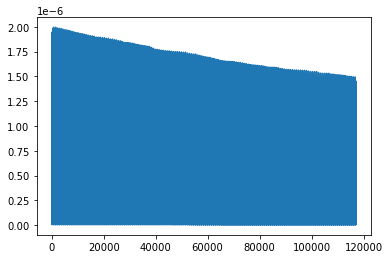

In [24]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.5)
pltdata13 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata13)

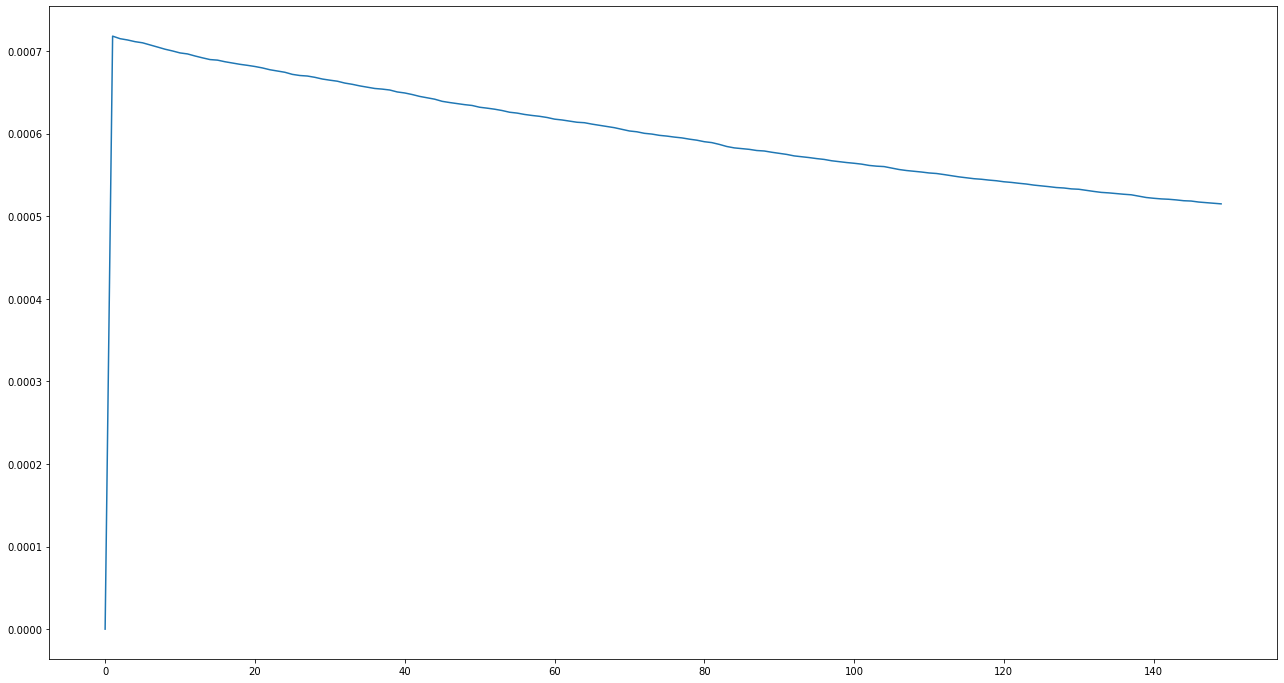

In [81]:
avg13 = 0
avgLossPerEpoch13 = []
for i in range(len(pltdata13)):
    avg13 = avg13 + pltdata13[i]
    if(i%780==0):
        avgLossPerEpoch13.append(avg13)
        avg13 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch13[0:150])       

learning rate  0.6
dev  cuda
[1,   100] loss: 0.0000000140
[1,   200] loss: 0.0000000131
[1,   300] loss: 0.0000000120
[1,   400] loss: 0.0000000149
[1,   500] loss: 0.0000000125
[1,   600] loss: 0.0000000132
[1,   700] loss: 0.0000000144
[2,   100] loss: 0.0000000140
[2,   200] loss: 0.0000000130
[2,   300] loss: 0.0000000120
[2,   400] loss: 0.0000000148
[2,   500] loss: 0.0000000124
[2,   600] loss: 0.0000000131
[2,   700] loss: 0.0000000144
[3,   100] loss: 0.0000000139
[3,   200] loss: 0.0000000130
[3,   300] loss: 0.0000000120
[3,   400] loss: 0.0000000148
[3,   500] loss: 0.0000000124
[3,   600] loss: 0.0000000131
[3,   700] loss: 0.0000000143
[4,   100] loss: 0.0000000139
[4,   200] loss: 0.0000000129
[4,   300] loss: 0.0000000119
[4,   400] loss: 0.0000000148
[4,   500] loss: 0.0000000123
[4,   600] loss: 0.0000000131
[4,   700] loss: 0.0000000143
[5,   100] loss: 0.0000000139
[5,   200] loss: 0.0000000129
[5,   300] loss: 0.0000000119
[5,   400] loss: 0.0000000147
[5,   500] 

[39,   100] loss: 0.0000000126
[39,   200] loss: 0.0000000121
[39,   300] loss: 0.0000000112
[39,   400] loss: 0.0000000136
[39,   500] loss: 0.0000000113
[39,   600] loss: 0.0000000121
[39,   700] loss: 0.0000000132
[40,   100] loss: 0.0000000125
[40,   200] loss: 0.0000000120
[40,   300] loss: 0.0000000111
[40,   400] loss: 0.0000000135
[40,   500] loss: 0.0000000113
[40,   600] loss: 0.0000000120
[40,   700] loss: 0.0000000132
[41,   100] loss: 0.0000000125
[41,   200] loss: 0.0000000120
[41,   300] loss: 0.0000000111
[41,   400] loss: 0.0000000135
[41,   500] loss: 0.0000000113
[41,   600] loss: 0.0000000120
[41,   700] loss: 0.0000000131
[42,   100] loss: 0.0000000125
[42,   200] loss: 0.0000000120
[42,   300] loss: 0.0000000111
[42,   400] loss: 0.0000000135
[42,   500] loss: 0.0000000113
[42,   600] loss: 0.0000000120
[42,   700] loss: 0.0000000130
[43,   100] loss: 0.0000000125
[43,   200] loss: 0.0000000120
[43,   300] loss: 0.0000000110
[43,   400] loss: 0.0000000135
[43,   5

[76,   700] loss: 0.0000000121
[77,   100] loss: 0.0000000116
[77,   200] loss: 0.0000000111
[77,   300] loss: 0.0000000102
[77,   400] loss: 0.0000000123
[77,   500] loss: 0.0000000104
[77,   600] loss: 0.0000000112
[77,   700] loss: 0.0000000121
[78,   100] loss: 0.0000000115
[78,   200] loss: 0.0000000110
[78,   300] loss: 0.0000000101
[78,   400] loss: 0.0000000123
[78,   500] loss: 0.0000000104
[78,   600] loss: 0.0000000112
[78,   700] loss: 0.0000000121
[79,   100] loss: 0.0000000115
[79,   200] loss: 0.0000000110
[79,   300] loss: 0.0000000101
[79,   400] loss: 0.0000000123
[79,   500] loss: 0.0000000104
[79,   600] loss: 0.0000000112
[79,   700] loss: 0.0000000121
[80,   100] loss: 0.0000000114
[80,   200] loss: 0.0000000110
[80,   300] loss: 0.0000000101
[80,   400] loss: 0.0000000122
[80,   500] loss: 0.0000000104
[80,   600] loss: 0.0000000112
[80,   700] loss: 0.0000000120
[81,   100] loss: 0.0000000114
[81,   200] loss: 0.0000000109
[81,   300] loss: 0.0000000101
[81,   4

[114,   300] loss: 0.0000000092
[114,   400] loss: 0.0000000112
[114,   500] loss: 0.0000000097
[114,   600] loss: 0.0000000105
[114,   700] loss: 0.0000000110
[115,   100] loss: 0.0000000107
[115,   200] loss: 0.0000000102
[115,   300] loss: 0.0000000091
[115,   400] loss: 0.0000000112
[115,   500] loss: 0.0000000096
[115,   600] loss: 0.0000000105
[115,   700] loss: 0.0000000110
[116,   100] loss: 0.0000000107
[116,   200] loss: 0.0000000102
[116,   300] loss: 0.0000000091
[116,   400] loss: 0.0000000112
[116,   500] loss: 0.0000000096
[116,   600] loss: 0.0000000105
[116,   700] loss: 0.0000000109
[117,   100] loss: 0.0000000107
[117,   200] loss: 0.0000000102
[117,   300] loss: 0.0000000091
[117,   400] loss: 0.0000000112
[117,   500] loss: 0.0000000096
[117,   600] loss: 0.0000000105
[117,   700] loss: 0.0000000109
[118,   100] loss: 0.0000000107
[118,   200] loss: 0.0000000102
[118,   300] loss: 0.0000000091
[118,   400] loss: 0.0000000111
[118,   500] loss: 0.0000000095
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.97 %


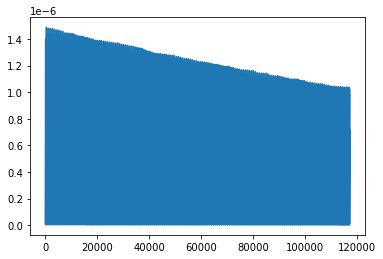

In [25]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.6)
pltdata14 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata14)

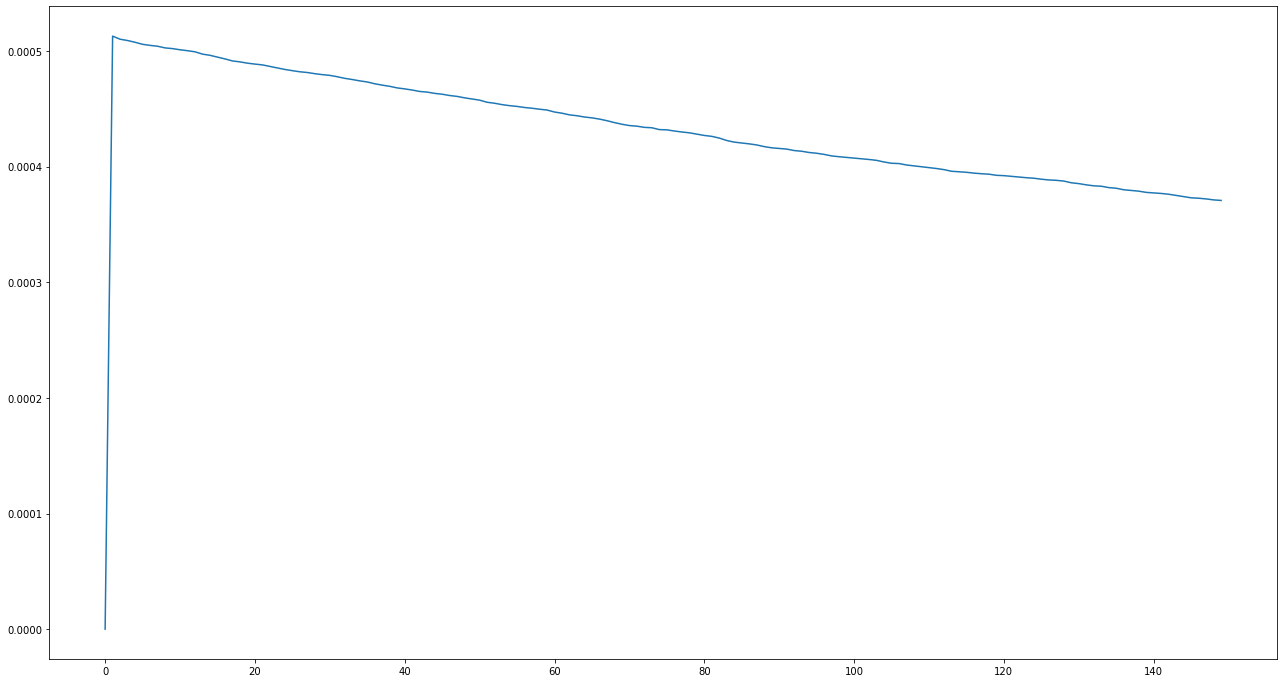

In [82]:
avg14 = 0
avgLossPerEpoch14 = []
for i in range(len(pltdata14)):
    avg14 = avg14 + pltdata14[i]
    if(i%780==0):
        avgLossPerEpoch14.append(avg14)
        avg14 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch14[0:150])       

learning rate  0.7
dev  cuda
[1,   100] loss: 0.0000000101
[1,   200] loss: 0.0000000095
[1,   300] loss: 0.0000000085
[1,   400] loss: 0.0000000104
[1,   500] loss: 0.0000000089
[1,   600] loss: 0.0000000099
[1,   700] loss: 0.0000000102
[2,   100] loss: 0.0000000101
[2,   200] loss: 0.0000000095
[2,   300] loss: 0.0000000085
[2,   400] loss: 0.0000000104
[2,   500] loss: 0.0000000088
[2,   600] loss: 0.0000000098
[2,   700] loss: 0.0000000102
[3,   100] loss: 0.0000000101
[3,   200] loss: 0.0000000095
[3,   300] loss: 0.0000000084
[3,   400] loss: 0.0000000103
[3,   500] loss: 0.0000000088
[3,   600] loss: 0.0000000098
[3,   700] loss: 0.0000000102
[4,   100] loss: 0.0000000101
[4,   200] loss: 0.0000000095
[4,   300] loss: 0.0000000084
[4,   400] loss: 0.0000000102
[4,   500] loss: 0.0000000088
[4,   600] loss: 0.0000000098
[4,   700] loss: 0.0000000102
[5,   100] loss: 0.0000000100
[5,   200] loss: 0.0000000094
[5,   300] loss: 0.0000000084
[5,   400] loss: 0.0000000102
[5,   500] 

[39,   100] loss: 0.0000000091
[39,   200] loss: 0.0000000086
[39,   300] loss: 0.0000000078
[39,   400] loss: 0.0000000094
[39,   500] loss: 0.0000000082
[39,   600] loss: 0.0000000091
[39,   700] loss: 0.0000000094
[40,   100] loss: 0.0000000091
[40,   200] loss: 0.0000000086
[40,   300] loss: 0.0000000078
[40,   400] loss: 0.0000000094
[40,   500] loss: 0.0000000081
[40,   600] loss: 0.0000000091
[40,   700] loss: 0.0000000094
[41,   100] loss: 0.0000000091
[41,   200] loss: 0.0000000086
[41,   300] loss: 0.0000000078
[41,   400] loss: 0.0000000094
[41,   500] loss: 0.0000000081
[41,   600] loss: 0.0000000091
[41,   700] loss: 0.0000000093
[42,   100] loss: 0.0000000091
[42,   200] loss: 0.0000000086
[42,   300] loss: 0.0000000078
[42,   400] loss: 0.0000000094
[42,   500] loss: 0.0000000081
[42,   600] loss: 0.0000000090
[42,   700] loss: 0.0000000093
[43,   100] loss: 0.0000000091
[43,   200] loss: 0.0000000086
[43,   300] loss: 0.0000000078
[43,   400] loss: 0.0000000093
[43,   5

[76,   700] loss: 0.0000000088
[77,   100] loss: 0.0000000084
[77,   200] loss: 0.0000000079
[77,   300] loss: 0.0000000070
[77,   400] loss: 0.0000000087
[77,   500] loss: 0.0000000074
[77,   600] loss: 0.0000000083
[77,   700] loss: 0.0000000088
[78,   100] loss: 0.0000000084
[78,   200] loss: 0.0000000078
[78,   300] loss: 0.0000000070
[78,   400] loss: 0.0000000087
[78,   500] loss: 0.0000000074
[78,   600] loss: 0.0000000082
[78,   700] loss: 0.0000000088
[79,   100] loss: 0.0000000083
[79,   200] loss: 0.0000000078
[79,   300] loss: 0.0000000070
[79,   400] loss: 0.0000000086
[79,   500] loss: 0.0000000074
[79,   600] loss: 0.0000000082
[79,   700] loss: 0.0000000088
[80,   100] loss: 0.0000000083
[80,   200] loss: 0.0000000078
[80,   300] loss: 0.0000000070
[80,   400] loss: 0.0000000086
[80,   500] loss: 0.0000000073
[80,   600] loss: 0.0000000082
[80,   700] loss: 0.0000000087
[81,   100] loss: 0.0000000083
[81,   200] loss: 0.0000000078
[81,   300] loss: 0.0000000070
[81,   4

[114,   300] loss: 0.0000000065
[114,   400] loss: 0.0000000083
[114,   500] loss: 0.0000000070
[114,   600] loss: 0.0000000077
[114,   700] loss: 0.0000000082
[115,   100] loss: 0.0000000077
[115,   200] loss: 0.0000000072
[115,   300] loss: 0.0000000065
[115,   400] loss: 0.0000000083
[115,   500] loss: 0.0000000069
[115,   600] loss: 0.0000000077
[115,   700] loss: 0.0000000082
[116,   100] loss: 0.0000000077
[116,   200] loss: 0.0000000071
[116,   300] loss: 0.0000000065
[116,   400] loss: 0.0000000083
[116,   500] loss: 0.0000000069
[116,   600] loss: 0.0000000076
[116,   700] loss: 0.0000000081
[117,   100] loss: 0.0000000076
[117,   200] loss: 0.0000000071
[117,   300] loss: 0.0000000065
[117,   400] loss: 0.0000000082
[117,   500] loss: 0.0000000069
[117,   600] loss: 0.0000000076
[117,   700] loss: 0.0000000081
[118,   100] loss: 0.0000000077
[118,   200] loss: 0.0000000071
[118,   300] loss: 0.0000000065
[118,   400] loss: 0.0000000082
[118,   500] loss: 0.0000000069
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.98 %


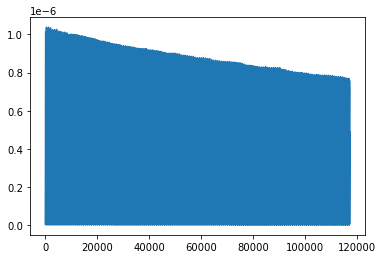

In [26]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.7)
pltdata15 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata15)

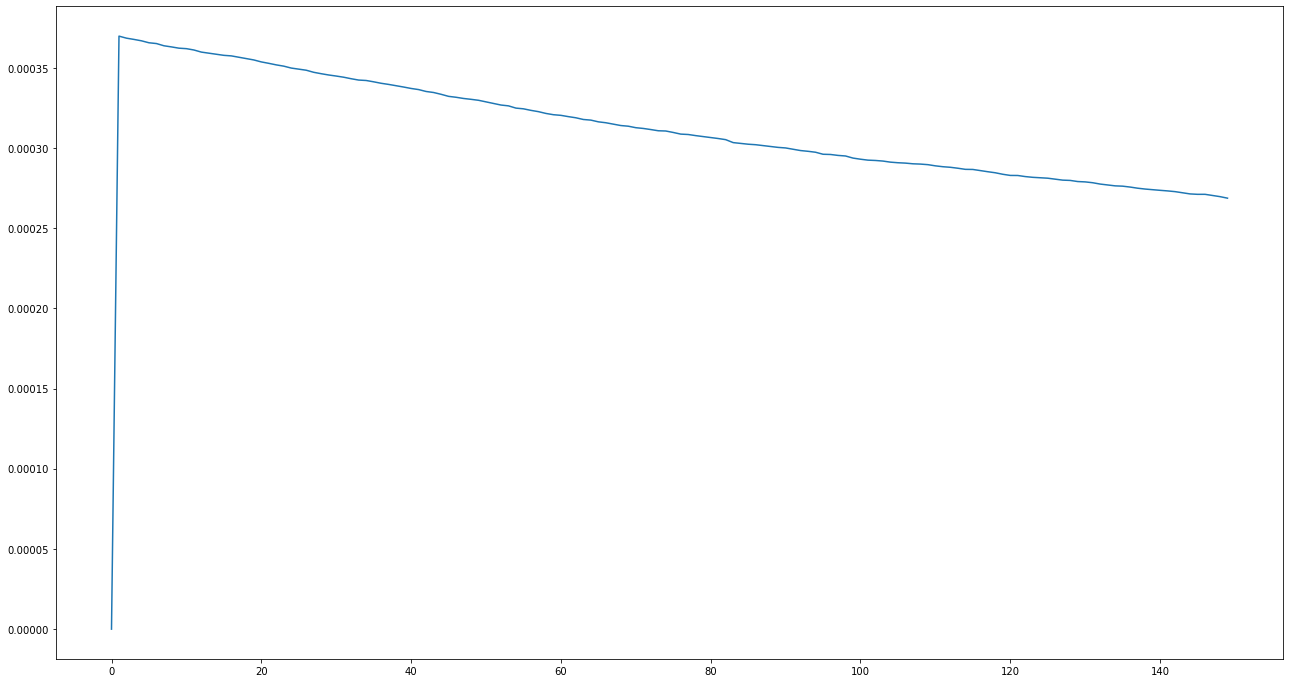

In [84]:
avg15 = 0
avgLossPerEpoch15 = []
for i in range(len(pltdata15)):
    avg15 = avg15 + pltdata15[i]
    if(i%780==0):
        avgLossPerEpoch15.append(avg15)
        avg15 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch15[0:150])       

learning rate  0.8
dev  cuda
[1,   100] loss: 0.0000000070
[1,   200] loss: 0.0000000067
[1,   300] loss: 0.0000000061
[1,   400] loss: 0.0000000077
[1,   500] loss: 0.0000000065
[1,   600] loss: 0.0000000072
[1,   700] loss: 0.0000000076
[2,   100] loss: 0.0000000070
[2,   200] loss: 0.0000000067
[2,   300] loss: 0.0000000061
[2,   400] loss: 0.0000000077
[2,   500] loss: 0.0000000065
[2,   600] loss: 0.0000000072
[2,   700] loss: 0.0000000076
[3,   100] loss: 0.0000000070
[3,   200] loss: 0.0000000067
[3,   300] loss: 0.0000000061
[3,   400] loss: 0.0000000077
[3,   500] loss: 0.0000000065
[3,   600] loss: 0.0000000071
[3,   700] loss: 0.0000000075
[4,   100] loss: 0.0000000070
[4,   200] loss: 0.0000000067
[4,   300] loss: 0.0000000061
[4,   400] loss: 0.0000000077
[4,   500] loss: 0.0000000065
[4,   600] loss: 0.0000000071
[4,   700] loss: 0.0000000075
[5,   100] loss: 0.0000000069
[5,   200] loss: 0.0000000067
[5,   300] loss: 0.0000000061
[5,   400] loss: 0.0000000077
[5,   500] 

[39,   100] loss: 0.0000000064
[39,   200] loss: 0.0000000062
[39,   300] loss: 0.0000000056
[39,   400] loss: 0.0000000070
[39,   500] loss: 0.0000000060
[39,   600] loss: 0.0000000066
[39,   700] loss: 0.0000000070
[40,   100] loss: 0.0000000064
[40,   200] loss: 0.0000000061
[40,   300] loss: 0.0000000056
[40,   400] loss: 0.0000000070
[40,   500] loss: 0.0000000060
[40,   600] loss: 0.0000000065
[40,   700] loss: 0.0000000070
[41,   100] loss: 0.0000000064
[41,   200] loss: 0.0000000061
[41,   300] loss: 0.0000000056
[41,   400] loss: 0.0000000070
[41,   500] loss: 0.0000000060
[41,   600] loss: 0.0000000065
[41,   700] loss: 0.0000000070
[42,   100] loss: 0.0000000064
[42,   200] loss: 0.0000000061
[42,   300] loss: 0.0000000056
[42,   400] loss: 0.0000000070
[42,   500] loss: 0.0000000060
[42,   600] loss: 0.0000000065
[42,   700] loss: 0.0000000070
[43,   100] loss: 0.0000000064
[43,   200] loss: 0.0000000061
[43,   300] loss: 0.0000000056
[43,   400] loss: 0.0000000070
[43,   5

[76,   700] loss: 0.0000000064
[77,   100] loss: 0.0000000059
[77,   200] loss: 0.0000000057
[77,   300] loss: 0.0000000053
[77,   400] loss: 0.0000000066
[77,   500] loss: 0.0000000056
[77,   600] loss: 0.0000000059
[77,   700] loss: 0.0000000063
[78,   100] loss: 0.0000000059
[78,   200] loss: 0.0000000057
[78,   300] loss: 0.0000000053
[78,   400] loss: 0.0000000065
[78,   500] loss: 0.0000000056
[78,   600] loss: 0.0000000059
[78,   700] loss: 0.0000000063
[79,   100] loss: 0.0000000059
[79,   200] loss: 0.0000000056
[79,   300] loss: 0.0000000052
[79,   400] loss: 0.0000000065
[79,   500] loss: 0.0000000055
[79,   600] loss: 0.0000000059
[79,   700] loss: 0.0000000063
[80,   100] loss: 0.0000000059
[80,   200] loss: 0.0000000056
[80,   300] loss: 0.0000000052
[80,   400] loss: 0.0000000065
[80,   500] loss: 0.0000000055
[80,   600] loss: 0.0000000059
[80,   700] loss: 0.0000000063
[81,   100] loss: 0.0000000059
[81,   200] loss: 0.0000000057
[81,   300] loss: 0.0000000052
[81,   4

[114,   300] loss: 0.0000000049
[114,   400] loss: 0.0000000059
[114,   500] loss: 0.0000000052
[114,   600] loss: 0.0000000055
[114,   700] loss: 0.0000000058
[115,   100] loss: 0.0000000056
[115,   200] loss: 0.0000000053
[115,   300] loss: 0.0000000049
[115,   400] loss: 0.0000000059
[115,   500] loss: 0.0000000052
[115,   600] loss: 0.0000000055
[115,   700] loss: 0.0000000058
[116,   100] loss: 0.0000000055
[116,   200] loss: 0.0000000053
[116,   300] loss: 0.0000000049
[116,   400] loss: 0.0000000058
[116,   500] loss: 0.0000000052
[116,   600] loss: 0.0000000055
[116,   700] loss: 0.0000000058
[117,   100] loss: 0.0000000055
[117,   200] loss: 0.0000000052
[117,   300] loss: 0.0000000048
[117,   400] loss: 0.0000000058
[117,   500] loss: 0.0000000052
[117,   600] loss: 0.0000000055
[117,   700] loss: 0.0000000057
[118,   100] loss: 0.0000000055
[118,   200] loss: 0.0000000053
[118,   300] loss: 0.0000000049
[118,   400] loss: 0.0000000058
[118,   500] loss: 0.0000000052
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.00 %


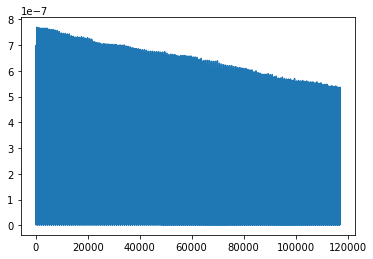

In [27]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.8)
pltdata16 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata16)

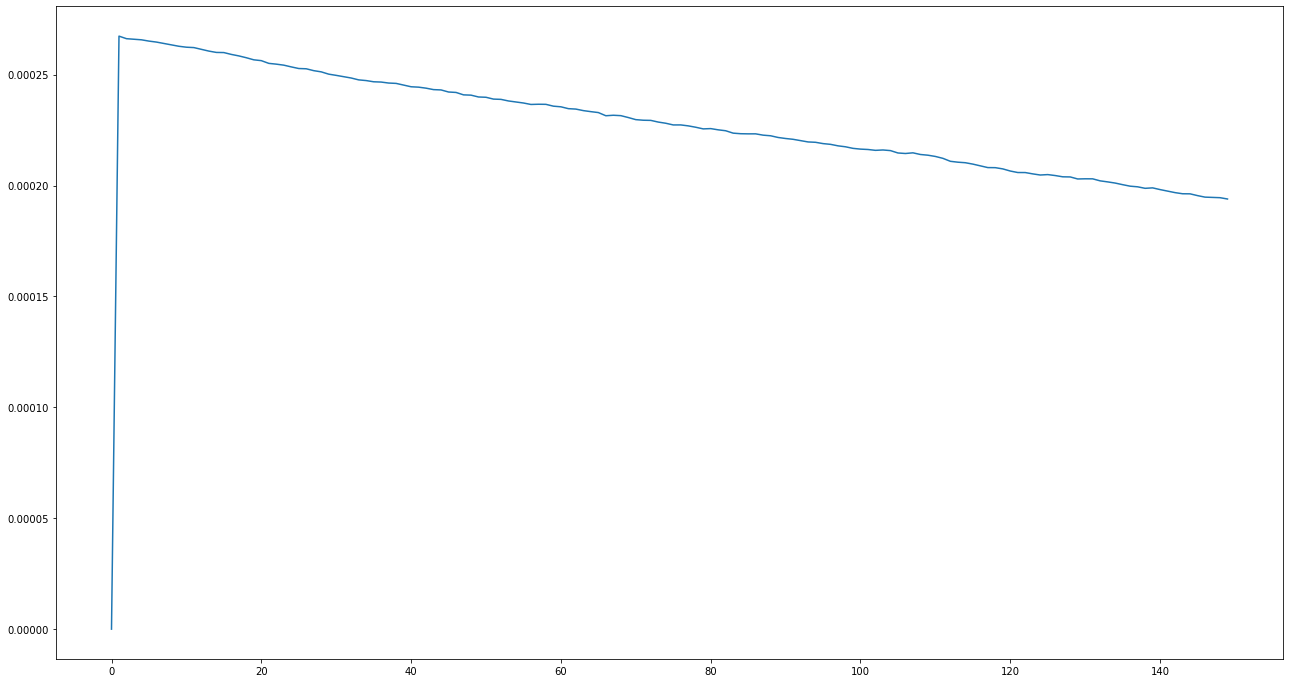

In [85]:
avg16 = 0
avgLossPerEpoch16 = []
for i in range(len(pltdata16)):
    avg16 = avg16 + pltdata16[i]
    if(i%780==0):
        avgLossPerEpoch16.append(avg16)
        avg16 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch16[0:150])       

learning rate  0.9
dev  cuda
[1,   100] loss: 0.0000000051
[1,   200] loss: 0.0000000048
[1,   300] loss: 0.0000000046
[1,   400] loss: 0.0000000054
[1,   500] loss: 0.0000000049
[1,   600] loss: 0.0000000050
[1,   700] loss: 0.0000000053
[2,   100] loss: 0.0000000051
[2,   200] loss: 0.0000000048
[2,   300] loss: 0.0000000046
[2,   400] loss: 0.0000000054
[2,   500] loss: 0.0000000049
[2,   600] loss: 0.0000000050
[2,   700] loss: 0.0000000053
[3,   100] loss: 0.0000000051
[3,   200] loss: 0.0000000048
[3,   300] loss: 0.0000000046
[3,   400] loss: 0.0000000053
[3,   500] loss: 0.0000000048
[3,   600] loss: 0.0000000050
[3,   700] loss: 0.0000000053
[4,   100] loss: 0.0000000051
[4,   200] loss: 0.0000000047
[4,   300] loss: 0.0000000046
[4,   400] loss: 0.0000000054
[4,   500] loss: 0.0000000048
[4,   600] loss: 0.0000000049
[4,   700] loss: 0.0000000053
[5,   100] loss: 0.0000000051
[5,   200] loss: 0.0000000047
[5,   300] loss: 0.0000000046
[5,   400] loss: 0.0000000053
[5,   500] 

[39,   100] loss: 0.0000000048
[39,   200] loss: 0.0000000043
[39,   300] loss: 0.0000000042
[39,   400] loss: 0.0000000049
[39,   500] loss: 0.0000000044
[39,   600] loss: 0.0000000044
[39,   700] loss: 0.0000000048
[40,   100] loss: 0.0000000047
[40,   200] loss: 0.0000000043
[40,   300] loss: 0.0000000042
[40,   400] loss: 0.0000000049
[40,   500] loss: 0.0000000044
[40,   600] loss: 0.0000000043
[40,   700] loss: 0.0000000049
[41,   100] loss: 0.0000000047
[41,   200] loss: 0.0000000042
[41,   300] loss: 0.0000000041
[41,   400] loss: 0.0000000049
[41,   500] loss: 0.0000000043
[41,   600] loss: 0.0000000043
[41,   700] loss: 0.0000000049
[42,   100] loss: 0.0000000047
[42,   200] loss: 0.0000000042
[42,   300] loss: 0.0000000042
[42,   400] loss: 0.0000000049
[42,   500] loss: 0.0000000043
[42,   600] loss: 0.0000000043
[42,   700] loss: 0.0000000049
[43,   100] loss: 0.0000000048
[43,   200] loss: 0.0000000042
[43,   300] loss: 0.0000000041
[43,   400] loss: 0.0000000049
[43,   5

[76,   700] loss: 0.0000000046
[77,   100] loss: 0.0000000043
[77,   200] loss: 0.0000000039
[77,   300] loss: 0.0000000038
[77,   400] loss: 0.0000000045
[77,   500] loss: 0.0000000039
[77,   600] loss: 0.0000000039
[77,   700] loss: 0.0000000046
[78,   100] loss: 0.0000000043
[78,   200] loss: 0.0000000039
[78,   300] loss: 0.0000000038
[78,   400] loss: 0.0000000045
[78,   500] loss: 0.0000000039
[78,   600] loss: 0.0000000039
[78,   700] loss: 0.0000000046
[79,   100] loss: 0.0000000043
[79,   200] loss: 0.0000000039
[79,   300] loss: 0.0000000038
[79,   400] loss: 0.0000000045
[79,   500] loss: 0.0000000039
[79,   600] loss: 0.0000000039
[79,   700] loss: 0.0000000045
[80,   100] loss: 0.0000000043
[80,   200] loss: 0.0000000039
[80,   300] loss: 0.0000000038
[80,   400] loss: 0.0000000045
[80,   500] loss: 0.0000000039
[80,   600] loss: 0.0000000038
[80,   700] loss: 0.0000000045
[81,   100] loss: 0.0000000043
[81,   200] loss: 0.0000000038
[81,   300] loss: 0.0000000038
[81,   4

[114,   300] loss: 0.0000000036
[114,   400] loss: 0.0000000040
[114,   500] loss: 0.0000000037
[114,   600] loss: 0.0000000036
[114,   700] loss: 0.0000000043
[115,   100] loss: 0.0000000040
[115,   200] loss: 0.0000000035
[115,   300] loss: 0.0000000035
[115,   400] loss: 0.0000000040
[115,   500] loss: 0.0000000037
[115,   600] loss: 0.0000000036
[115,   700] loss: 0.0000000043
[116,   100] loss: 0.0000000040
[116,   200] loss: 0.0000000035
[116,   300] loss: 0.0000000036
[116,   400] loss: 0.0000000040
[116,   500] loss: 0.0000000037
[116,   600] loss: 0.0000000036
[116,   700] loss: 0.0000000042
[117,   100] loss: 0.0000000040
[117,   200] loss: 0.0000000035
[117,   300] loss: 0.0000000036
[117,   400] loss: 0.0000000040
[117,   500] loss: 0.0000000037
[117,   600] loss: 0.0000000036
[117,   700] loss: 0.0000000042
[118,   100] loss: 0.0000000039
[118,   200] loss: 0.0000000034
[118,   300] loss: 0.0000000035
[118,   400] loss: 0.0000000040
[118,   500] loss: 0.0000000037
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.01 %


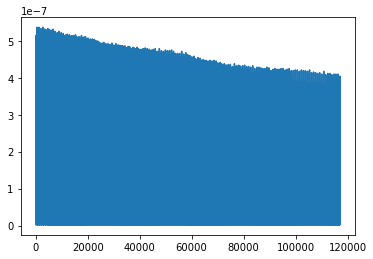

In [28]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.9)
pltdata17 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata17)

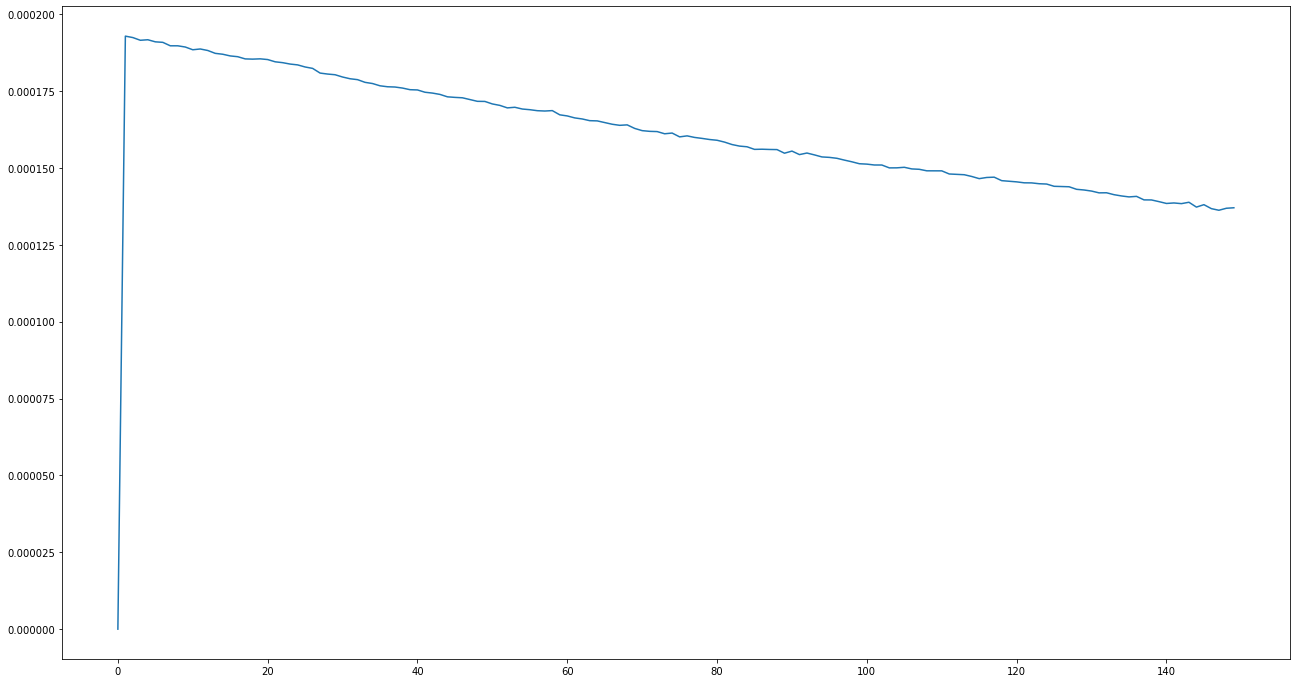

In [86]:
avg17 = 0
avgLossPerEpoch17 = []
for i in range(len(pltdata17)):
    avg17 = avg17 + pltdata17[i]
    if(i%780==0):
        avgLossPerEpoch17.append(avg17)
        avg17 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch17[0:150])       

learning rate  0.11
dev  cuda
[1,   100] loss: 0.0000000037
[1,   200] loss: 0.0000000033
[1,   300] loss: 0.0000000032
[1,   400] loss: 0.0000000038
[1,   500] loss: 0.0000000034
[1,   600] loss: 0.0000000032
[1,   700] loss: 0.0000000040
[2,   100] loss: 0.0000000037
[2,   200] loss: 0.0000000033
[2,   300] loss: 0.0000000032
[2,   400] loss: 0.0000000038
[2,   500] loss: 0.0000000034
[2,   600] loss: 0.0000000032
[2,   700] loss: 0.0000000040
[3,   100] loss: 0.0000000037
[3,   200] loss: 0.0000000033
[3,   300] loss: 0.0000000032
[3,   400] loss: 0.0000000038
[3,   500] loss: 0.0000000034
[3,   600] loss: 0.0000000032
[3,   700] loss: 0.0000000040
[4,   100] loss: 0.0000000037
[4,   200] loss: 0.0000000033
[4,   300] loss: 0.0000000032
[4,   400] loss: 0.0000000038
[4,   500] loss: 0.0000000034
[4,   600] loss: 0.0000000032
[4,   700] loss: 0.0000000040
[5,   100] loss: 0.0000000037
[5,   200] loss: 0.0000000033
[5,   300] loss: 0.0000000032
[5,   400] loss: 0.0000000038
[5,   500]

[39,   100] loss: 0.0000000036
[39,   200] loss: 0.0000000033
[39,   300] loss: 0.0000000032
[39,   400] loss: 0.0000000038
[39,   500] loss: 0.0000000034
[39,   600] loss: 0.0000000032
[39,   700] loss: 0.0000000040
[40,   100] loss: 0.0000000036
[40,   200] loss: 0.0000000033
[40,   300] loss: 0.0000000032
[40,   400] loss: 0.0000000038
[40,   500] loss: 0.0000000034
[40,   600] loss: 0.0000000032
[40,   700] loss: 0.0000000041
[41,   100] loss: 0.0000000036
[41,   200] loss: 0.0000000033
[41,   300] loss: 0.0000000032
[41,   400] loss: 0.0000000038
[41,   500] loss: 0.0000000034
[41,   600] loss: 0.0000000032
[41,   700] loss: 0.0000000041
[42,   100] loss: 0.0000000036
[42,   200] loss: 0.0000000033
[42,   300] loss: 0.0000000032
[42,   400] loss: 0.0000000038
[42,   500] loss: 0.0000000034
[42,   600] loss: 0.0000000032
[42,   700] loss: 0.0000000041
[43,   100] loss: 0.0000000036
[43,   200] loss: 0.0000000033
[43,   300] loss: 0.0000000032
[43,   400] loss: 0.0000000037
[43,   5

[76,   700] loss: 0.0000000041
[77,   100] loss: 0.0000000036
[77,   200] loss: 0.0000000033
[77,   300] loss: 0.0000000032
[77,   400] loss: 0.0000000038
[77,   500] loss: 0.0000000033
[77,   600] loss: 0.0000000032
[77,   700] loss: 0.0000000040
[78,   100] loss: 0.0000000036
[78,   200] loss: 0.0000000033
[78,   300] loss: 0.0000000032
[78,   400] loss: 0.0000000037
[78,   500] loss: 0.0000000034
[78,   600] loss: 0.0000000032
[78,   700] loss: 0.0000000041
[79,   100] loss: 0.0000000036
[79,   200] loss: 0.0000000033
[79,   300] loss: 0.0000000032
[79,   400] loss: 0.0000000038
[79,   500] loss: 0.0000000034
[79,   600] loss: 0.0000000032
[79,   700] loss: 0.0000000041
[80,   100] loss: 0.0000000036
[80,   200] loss: 0.0000000032
[80,   300] loss: 0.0000000032
[80,   400] loss: 0.0000000038
[80,   500] loss: 0.0000000033
[80,   600] loss: 0.0000000032
[80,   700] loss: 0.0000000041
[81,   100] loss: 0.0000000036
[81,   200] loss: 0.0000000033
[81,   300] loss: 0.0000000032
[81,   4

[114,   300] loss: 0.0000000032
[114,   400] loss: 0.0000000038
[114,   500] loss: 0.0000000033
[114,   600] loss: 0.0000000032
[114,   700] loss: 0.0000000041
[115,   100] loss: 0.0000000036
[115,   200] loss: 0.0000000033
[115,   300] loss: 0.0000000032
[115,   400] loss: 0.0000000038
[115,   500] loss: 0.0000000033
[115,   600] loss: 0.0000000032
[115,   700] loss: 0.0000000041
[116,   100] loss: 0.0000000036
[116,   200] loss: 0.0000000032
[116,   300] loss: 0.0000000032
[116,   400] loss: 0.0000000038
[116,   500] loss: 0.0000000033
[116,   600] loss: 0.0000000032
[116,   700] loss: 0.0000000041
[117,   100] loss: 0.0000000036
[117,   200] loss: 0.0000000032
[117,   300] loss: 0.0000000032
[117,   400] loss: 0.0000000038
[117,   500] loss: 0.0000000033
[117,   600] loss: 0.0000000032
[117,   700] loss: 0.0000000041
[118,   100] loss: 0.0000000036
[118,   200] loss: 0.0000000033
[118,   300] loss: 0.0000000032
[118,   400] loss: 0.0000000038
[118,   500] loss: 0.0000000033
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.01 %


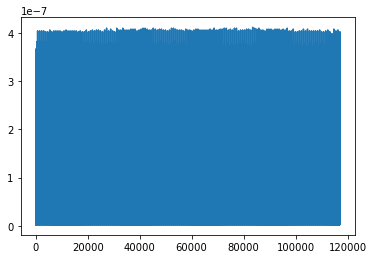

In [29]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.11)
pltdata18 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata18)

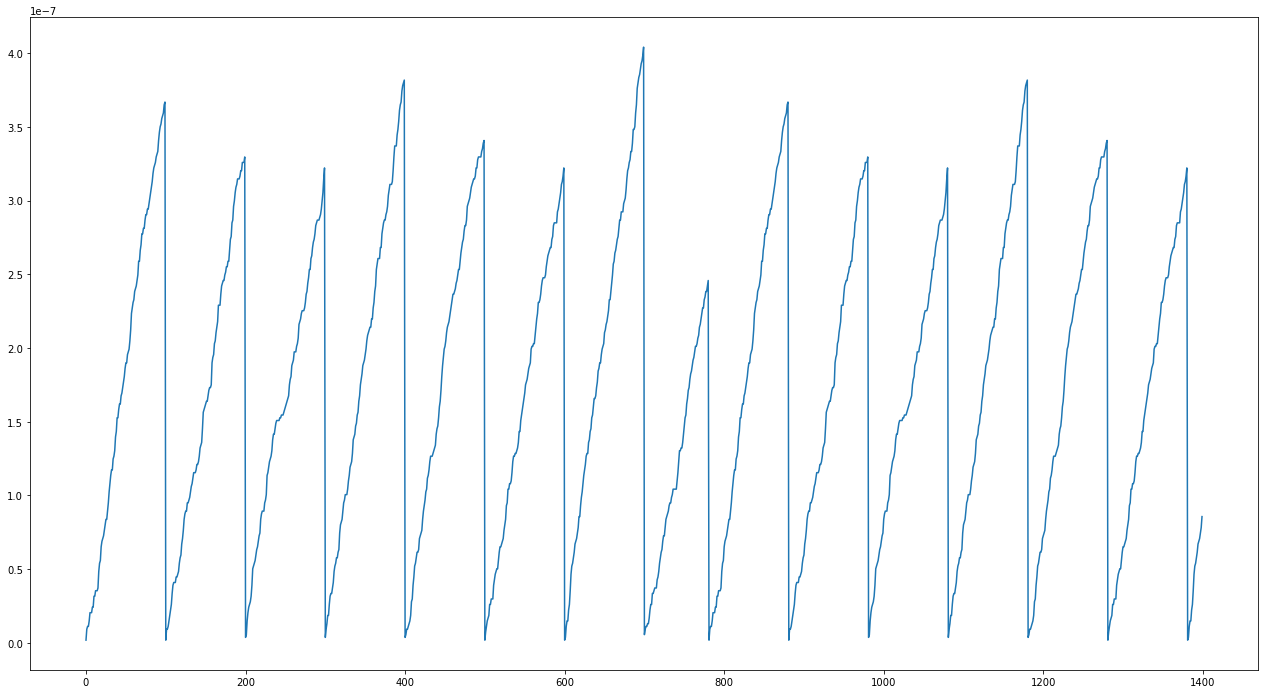

In [40]:
plt.figure(figsize=(22, 12))
plt.plot(pltdata18[0:1400])

In [94]:
avg18 = 0
avgLossPerEpoch18 = []
for i in range(len(pltdata18)):
    avg18 = avg18 + pltdata18[i]
    if(i%780==0):
        avgLossPerEpoch18.append(avg18)
        avg18 = 0

In [95]:
len(avgLossPerEpoch18)

151

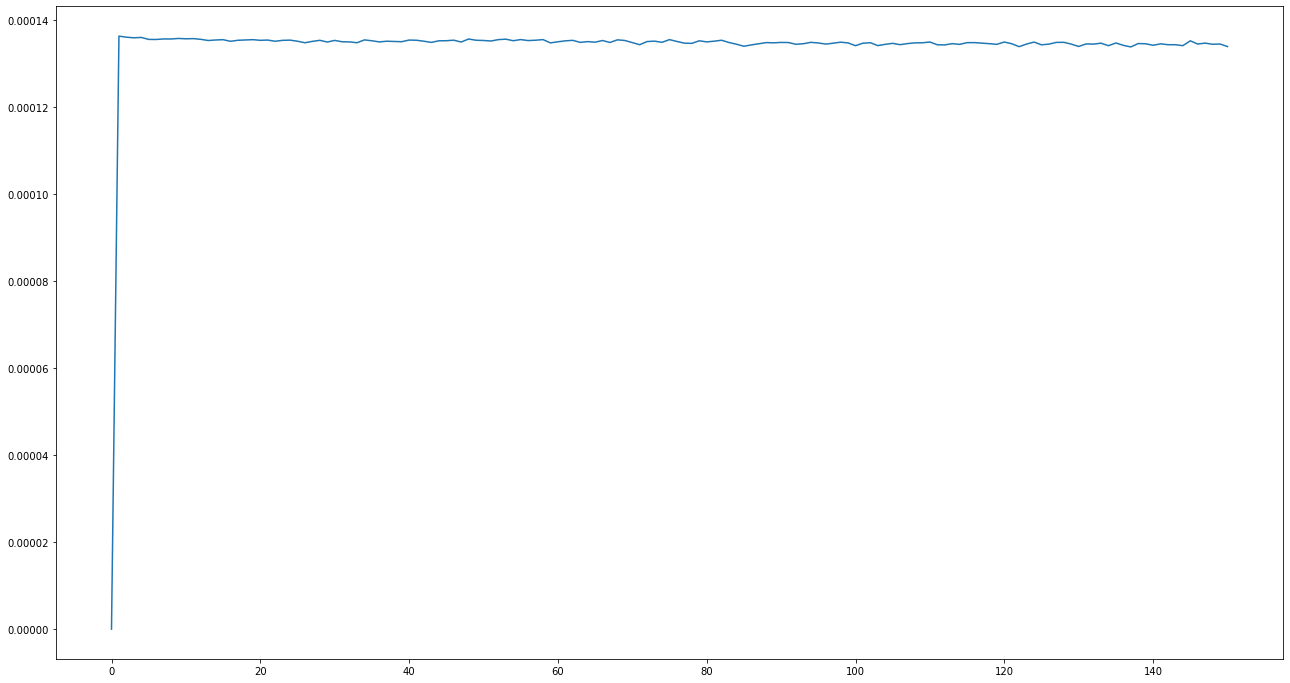

In [96]:
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch18)

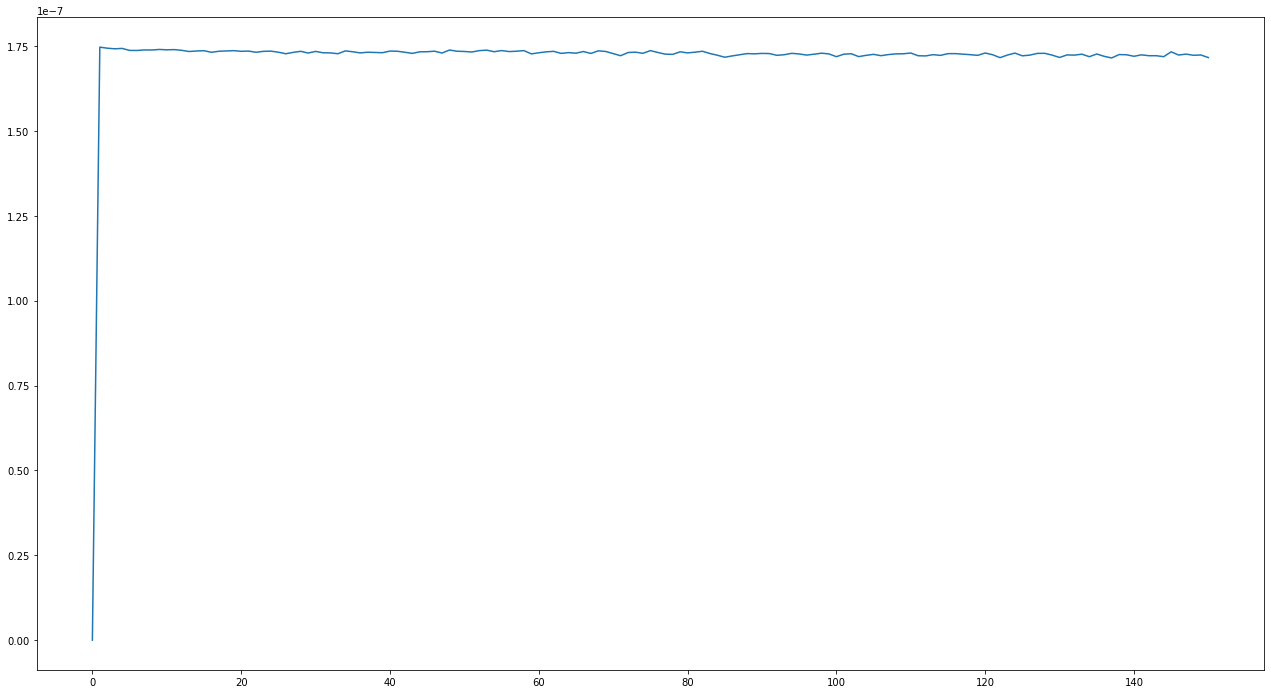

In [99]:
avg18 = 0
avgLossPerEpoch18 = []
for i in range(len(pltdata18)):
    avg18 = avg18 + pltdata18[i]
    if(i%780==0):
        avgLossPerEpoch18.append(avg18/780)
        avg18 = 0

plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch18)

# END